```
This software is a part of GPU Ocean.

Copyright (C) 2018-2019  SINTEF Digital

In this notebook we test the two-stage IEWPF algorithm on a
OceanNoiseEnsemble.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

# Two Stage Implicit Equal Weights Particle Filter

This notebook implements prototyping and example/demo of the two stage Implicit Equal Weights Particle Filter (IEWPF).


## Set environment

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation, rc
from scipy.special import lambertw

import pycuda.driver as cuda

import os
import sys
from importlib import reload

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))

#Set large figure sizes
rc('figure', figsize=(16.0, 12.0))
rc('animation', html='html5')
matplotlib.rcParams['contour.negative_linestyle'] = 'solid'

#Import our simulator
from SWESimulators import CDKLM16, PlotHelper, Common, IPythonMagic, config

from SWESimulators import BathymetryAndICs as BC
from SWESimulators import OceanStateNoise
from SWESimulators import OceanNoiseEnsemble
from SWESimulators import BaseOceanStateEnsemble
from SWESimulators import DataAssimilationUtils as dautils
from SWESimulators import IEWPFOcean
from SWESimulators import EnsemblePlot



In [2]:
%cuda_context_handler gpu_ctx
%setup_logging --out iewpf_2stage_gpu.log --file_level $config.GPUOceanLoggerLevels.IEWPF_DEBUG.value

Console logger using level INFO
File logger using level Level 15 to iewpf_2stage_gpu.log
Python version 3.7.8 | packaged by conda-forge | (default, Jul 31 2020, 01:53:57) [MSC v.1916 64 bit (AMD64)]


# Testing two-stage IEWPF

Here, we make a test of the entire two-stage IEWPF algorithm applied to a suitable test case.

In [3]:
# DEFINE PARAMETERS

sim_args = {
    "gpu_ctx": gpu_ctx,
    "nx": 120, "ny": 120,
    #"nx": 15, "ny": 15,
    "dx": 4.0, "dy": 4.0,
    "dt": 0.05,
    "g": 9.81,
    "f": 0.05,
    "coriolis_beta": 0.0,
    "r": 0.0,
    "rk_order": 2,
    "small_scale_perturbation_amplitude": None,
    "write_netcdf": False, 
    "small_scale_perturbation": True,
    #"small_scale_perturbation_interpolation_factor": 1,
    "small_scale_perturbation_interpolation_factor": 3,
    "boundary_conditions": Common.BoundaryConditions(2,2,2,2)
}

ghosts = np.array([2,2,2,2]) # north, east, south, west
validDomain = np.array([2,2,2,2])


dataShape = (sim_args["ny"] + ghosts[0]+ghosts[2], 
             sim_args["nx"] + ghosts[1]+ghosts[3])
dataShapeHi = (sim_args["ny"] + ghosts[0]+ghosts[2]+1, 
             sim_args["nx"] + ghosts[1]+ghosts[3]+1)

sim_args["eta0"] = np.zeros(dataShape, dtype=np.float32, order='C');
sim_args["hv0"] = np.zeros(dataShape, dtype=np.float32, order='C');
sim_args["hu0"] = np.zeros(dataShape, dtype=np.float32, order='C');
waterDepth = 10.0
sim_args["H"] = np.ones(dataShapeHi, dtype=np.float32, order='C')*waterDepth


if 'sim' in globals():
    sim.cleanUp()
if 'ensemble' in globals():
    ensemble.cleanUp()
if 'iewpfOcean' in globals():
    iewpfOcean.cleanUp()
    
sim_args["small_scale_perturbation_amplitude"] = np.sqrt(sim_args["dt"])*0.5*sim_args["f"]/(sim_args["g"]*waterDepth)
sim_args["small_scale_perturbation_amplitude"] *= sim_args["small_scale_perturbation_interpolation_factor"]
print ("q0: ", sim_args["small_scale_perturbation_amplitude"])
print ("[f, g, H, dt]", [sim_args["f"], sim_args["g"], waterDepth, sim_args["dt"]])
print ("(nx, ny): ", (sim_args["nx"], sim_args["ny"]))

reload(CDKLM16)
reload(BaseOceanStateEnsemble)
reload(OceanNoiseEnsemble)
reload(PlotHelper)
reload(dautils)
reload(IEWPFOcean)

sim = CDKLM16.CDKLM16(**sim_args)
sim.perturbState(q0_scale=100)
    
eta_init, hu_init, hv_init = sim.download(True)
    
ensemble_args = {
    "gpu_ctx": gpu_ctx,
    "numParticles": 30,
    "num_drifters": 3,
    "sim": sim,
    "observation_type": dautils.ObservationType.DirectUnderlyingFlow,
    "observation_variance": 0.02**2
}

ensemble = OceanNoiseEnsemble.OceanNoiseEnsemble(**ensemble_args)

max_dt = ensemble.findLargestPossibleTimeStep()
print ("max_dt: ", max_dt)

iewpfOcean = IEWPFOcean.IEWPFOcean(ensemble, debug=False, show_errors=True)

print ("Ready!")
#ensemble.plotEnsemble()

q0:  0.00017095320928897472
[f, g, H, dt] [0.05, 9.81, 10.0, 0.05]
(nx, ny):  (120, 120)
max_dt:  0.09036847203969955
Ready!


In [4]:
infoPlots = []
with Common.Timer("IEWPF") as timer:
   


    T = 120
    #T = 30
    sub_t = 5*sim_args["dt"]
    observation_iterations = range(15, 100, 10)

    tot_time_sim = 0.0
    tot_time_da = 0.0

    for i in range(T):
        
        start = cuda.Event()
        end = cuda.Event()
        iewpf_event = cuda.Event()
        
        start.record(iewpfOcean.master_stream)
        t = ensemble.step(sub_t)
        end.record(iewpfOcean.master_stream)
                
        end.synchronize()
        gpu_elapsed = end.time_since(start)*1.0e-3
        #print "iteration " + str(i) + " took: " + str(gpu_elapsed) 
        tot_time_sim = tot_time_sim + gpu_elapsed
        
        for oi in observation_iterations:
            if i == oi:
                print ("Enter IEWPF for observation time ", i)
                iewpfOcean.iewpf_2stage(ensemble, infoPlots, i)
                
                
                iewpf_event.record(iewpfOcean.master_stream)
                iewpf_event.synchronize()
                gpu_elapsed = iewpf_event.time_since(end)*1.0e-3
                #print "------\nFull IEWPF took: " + str(gpu_elapsed) + "\n----------"
                tot_time_da = tot_time_da + gpu_elapsed
        ensemble.getEnsembleVarAndRMSEUnderDrifter(i)
        
        
print("IEWPF took " + str(timer.secs))
print("Total event time sim: " + str(tot_time_sim))
print("Total event time DA: " + str(tot_time_da))
print("Total event time all: " + str(tot_time_sim + tot_time_da))

print("Num timesteps: " + str(T*sub_t/sim_args["dt"]))
print("Num DA steps:  " + str(len(observation_iterations)))
print("domain size:   " + str((sim_args["nx"], sim_args["ny"])))
print("num drifters:  " + str((ensemble.driftersPerOceanModel)))

Enter IEWPF for observation time  15
Enter IEWPF for observation time  25
Enter IEWPF for observation time  35
Enter IEWPF for observation time  45
Enter IEWPF for observation time  55
Enter IEWPF for observation time  65
Enter IEWPF for observation time  75
Enter IEWPF for observation time  85
Enter IEWPF for observation time  95
IEWPF took 32.664342641830444
Total event time sim: 4.760036296844483
Total event time DA: 24.757919189453126
Total event time all: 29.51795548629761
Num timesteps: 600.0
Num DA steps:  9
domain size:   (120, 120)
num drifters:  3


iewpf_two_stage_20180720_figures/it_15_before_IEWPF.png
iewpf_two_stage_20180720_figures/it_15_after_IEWPF.png
iewpf_two_stage_20180720_figures/it_25_before_IEWPF.png
iewpf_two_stage_20180720_figures/it_25_after_IEWPF.png
iewpf_two_stage_20180720_figures/it_35_before_IEWPF.png
iewpf_two_stage_20180720_figures/it_35_after_IEWPF.png
iewpf_two_stage_20180720_figures/it_45_before_IEWPF.png
iewpf_two_stage_20180720_figures/it_45_after_IEWPF.png
iewpf_two_stage_20180720_figures/it_55_before_IEWPF.png
iewpf_two_stage_20180720_figures/it_55_after_IEWPF.png
iewpf_two_stage_20180720_figures/it_65_before_IEWPF.png
iewpf_two_stage_20180720_figures/it_65_after_IEWPF.png
iewpf_two_stage_20180720_figures/it_75_before_IEWPF.png
iewpf_two_stage_20180720_figures/it_75_after_IEWPF.png
iewpf_two_stage_20180720_figures/it_85_before_IEWPF.png
iewpf_two_stage_20180720_figures/it_85_after_IEWPF.png
iewpf_two_stage_20180720_figures/it_95_before_IEWPF.png
iewpf_two_stage_20180720_figures/it_95_after_IEWPF.png


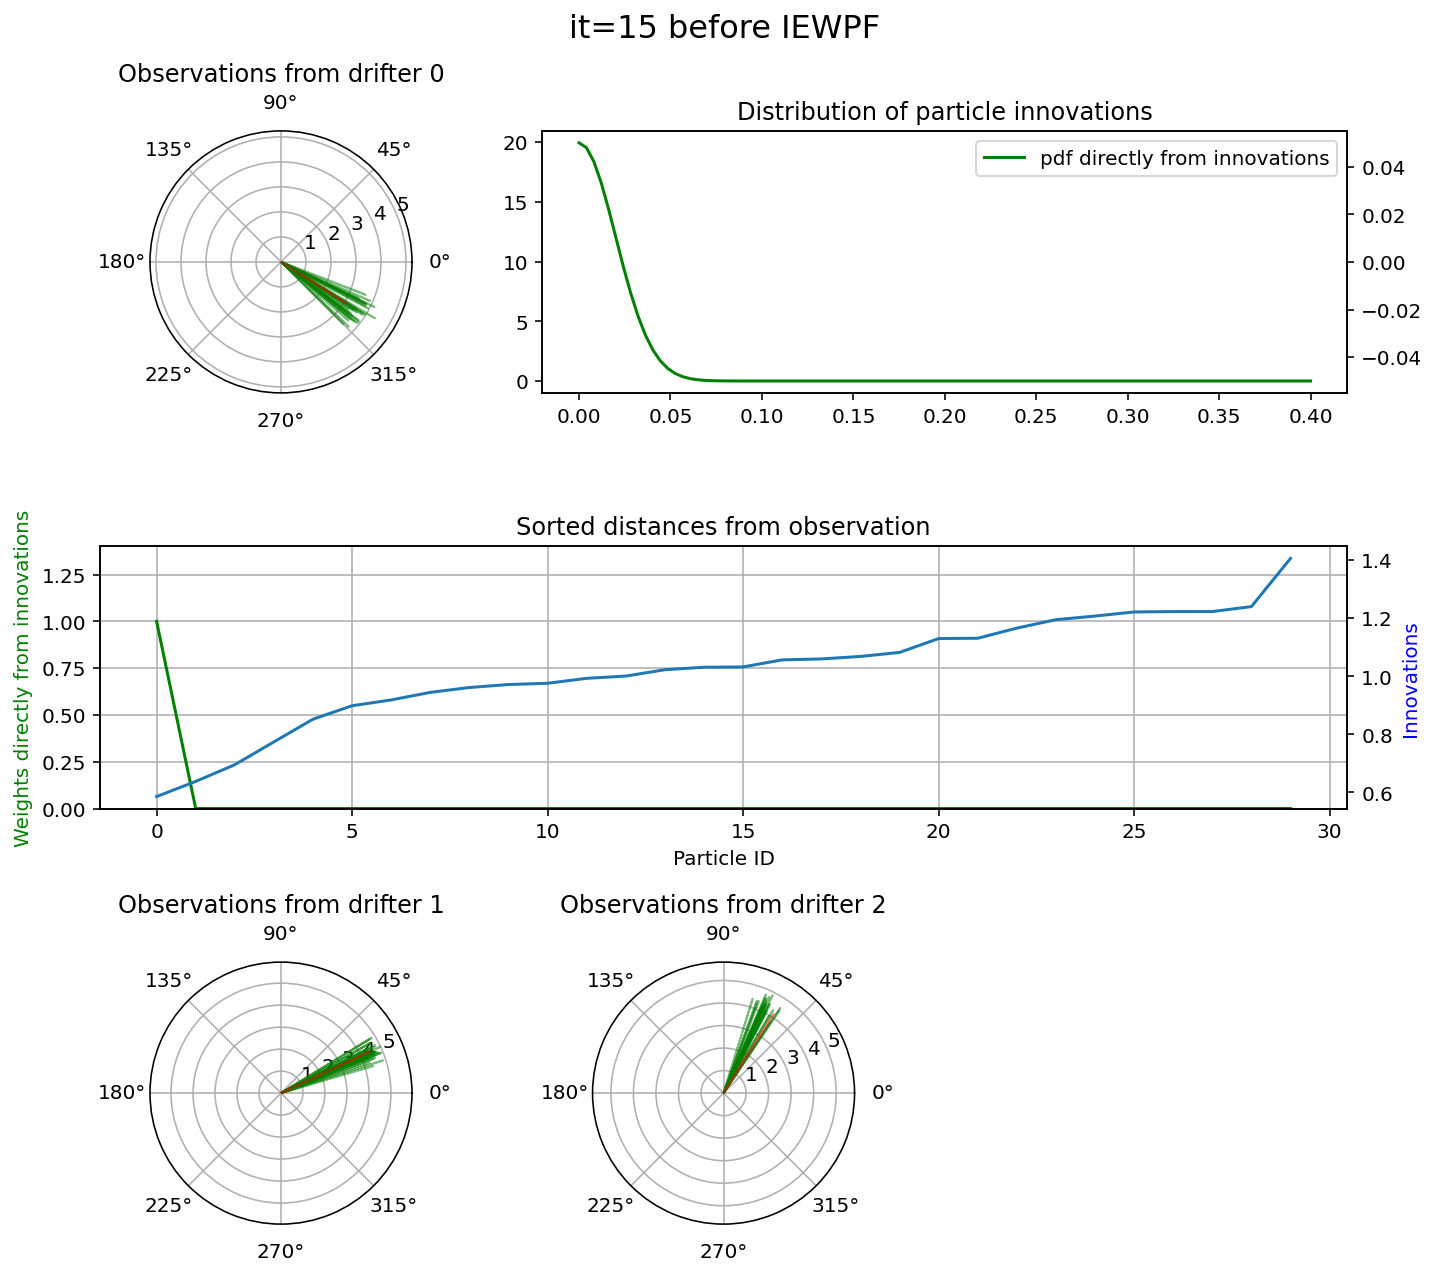

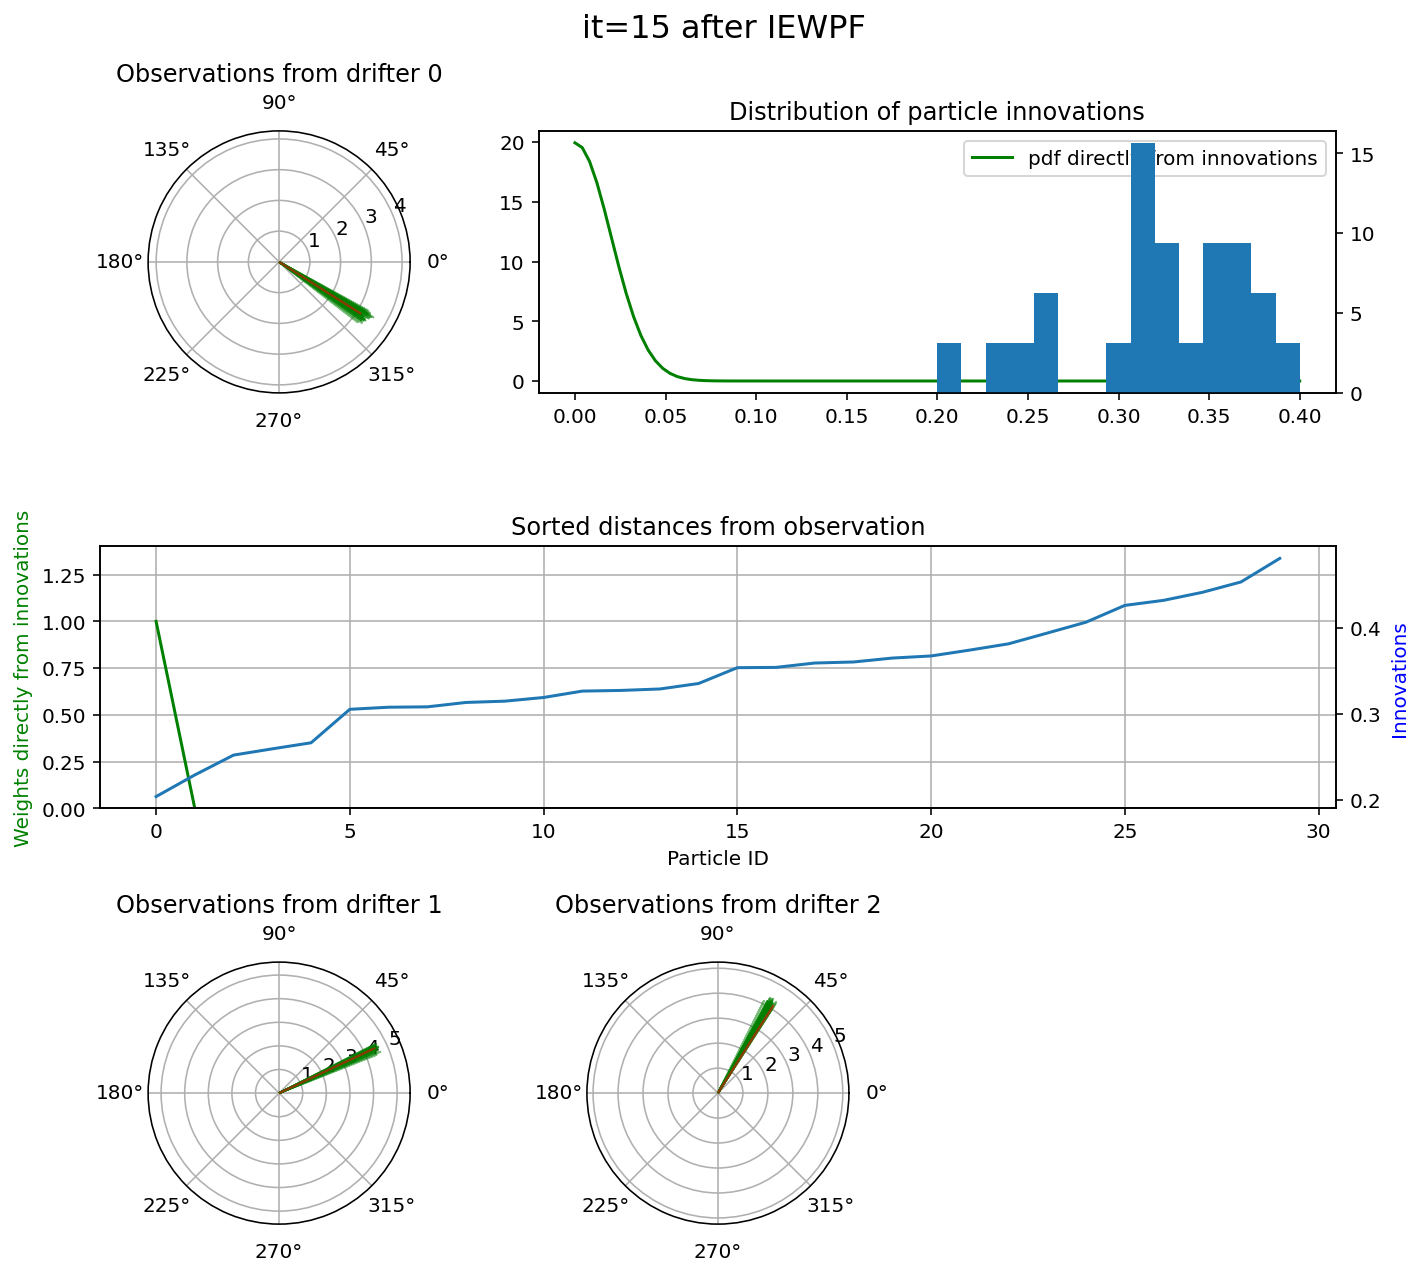

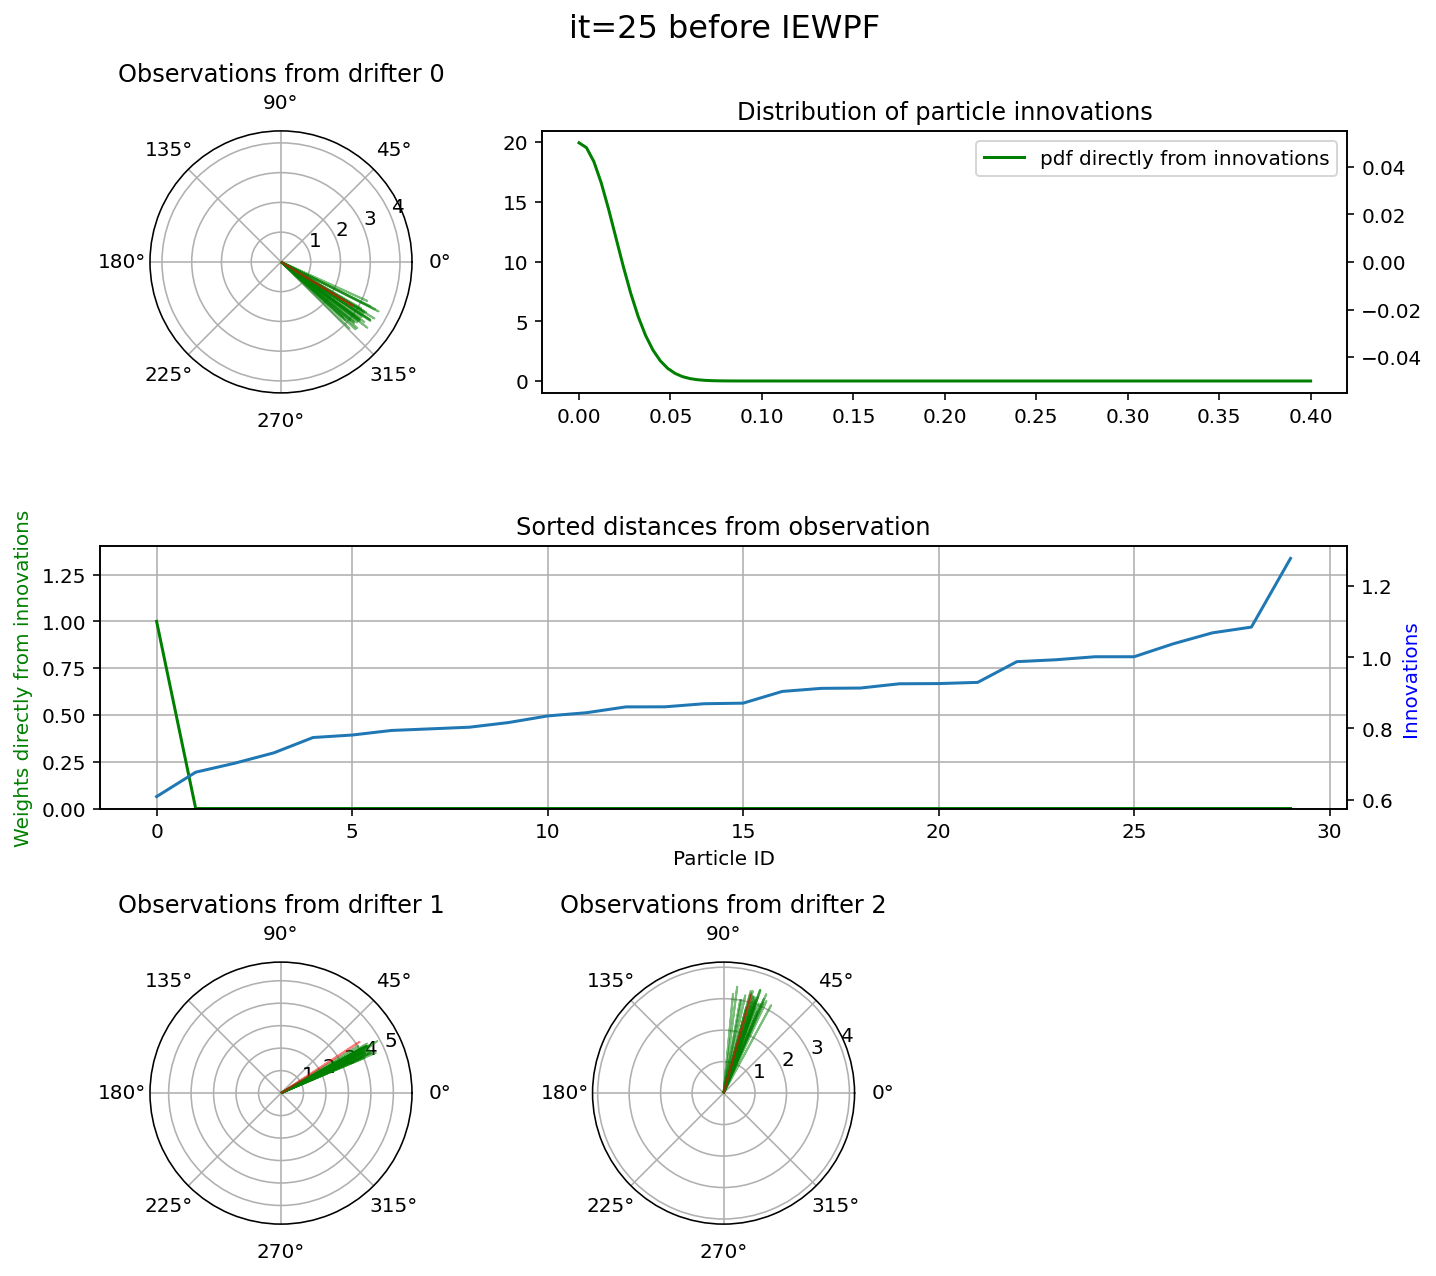

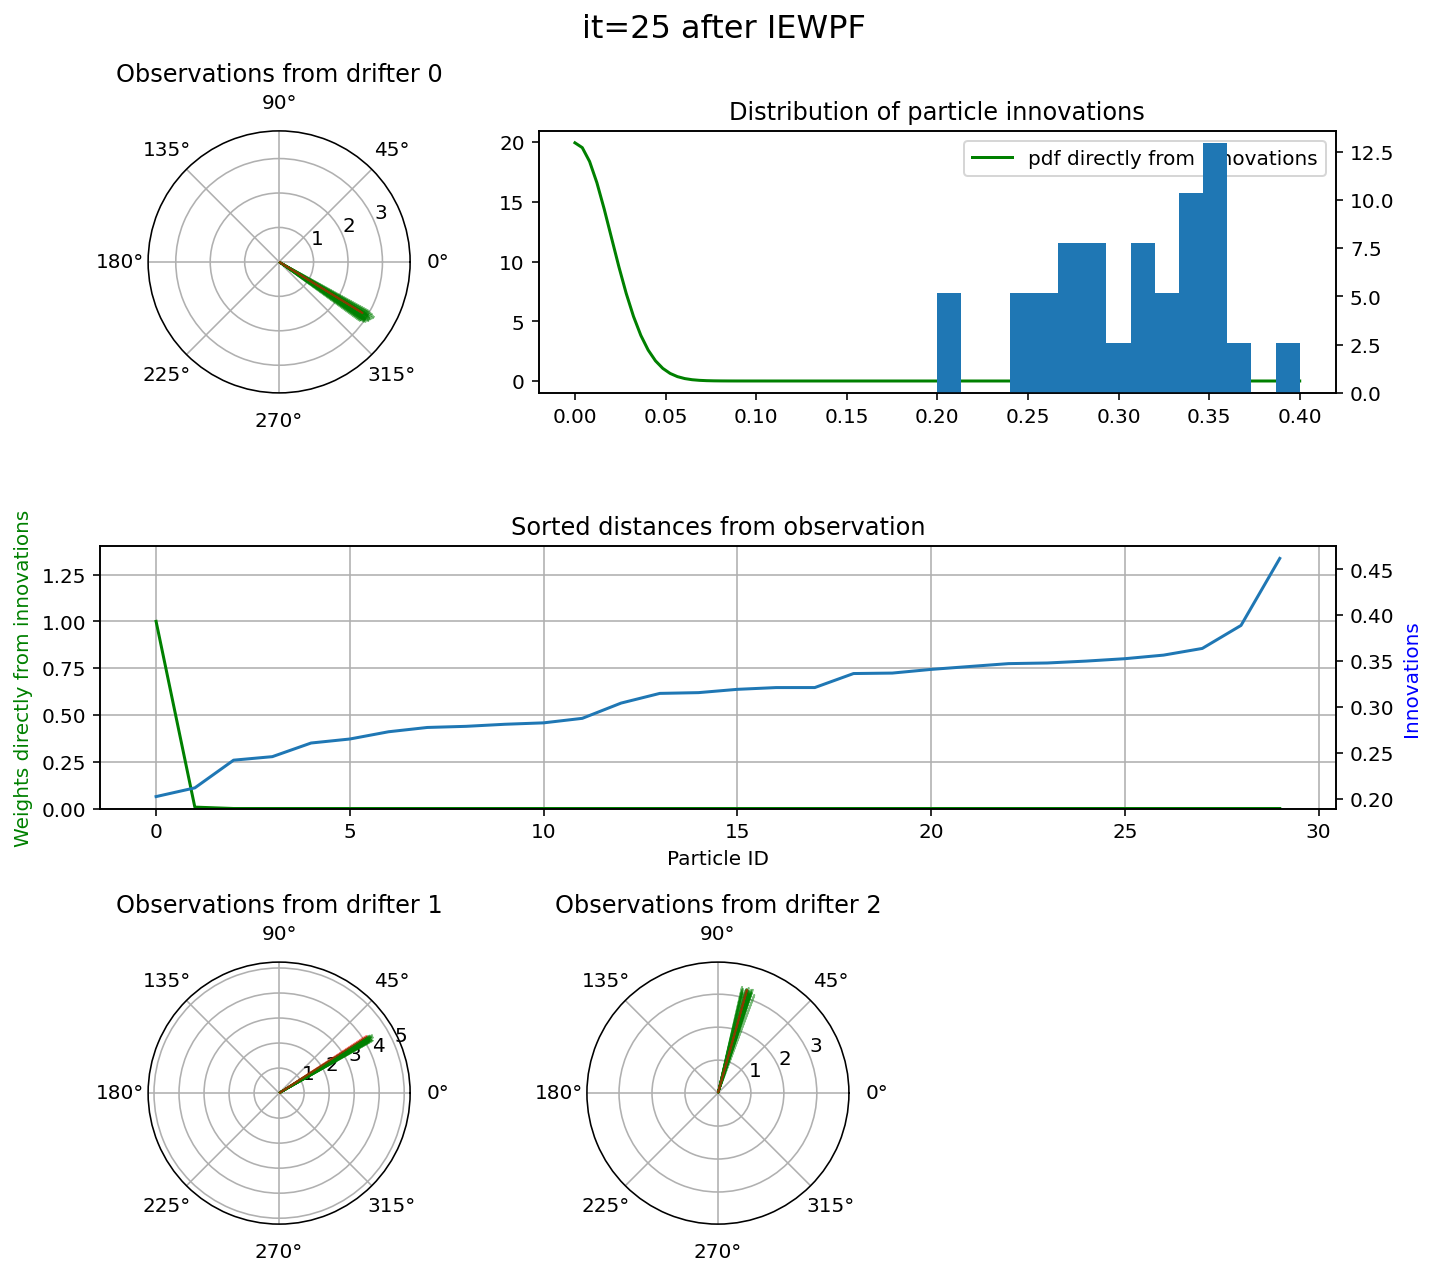

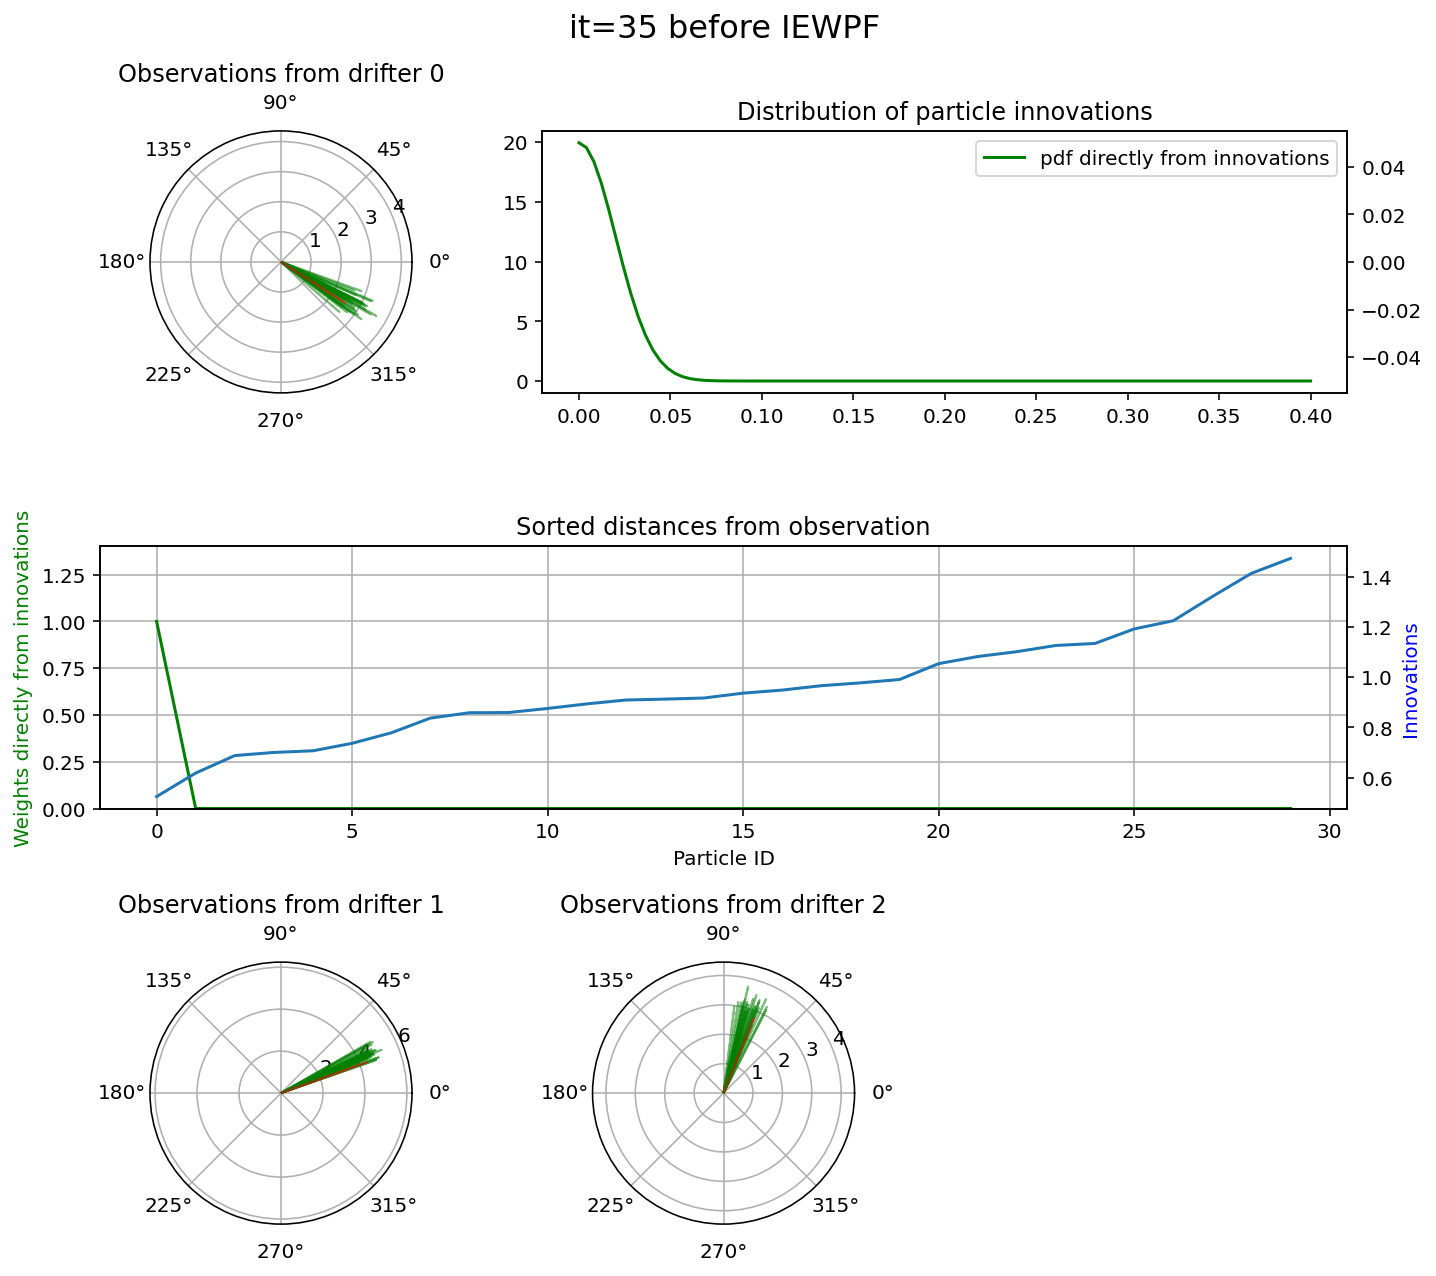

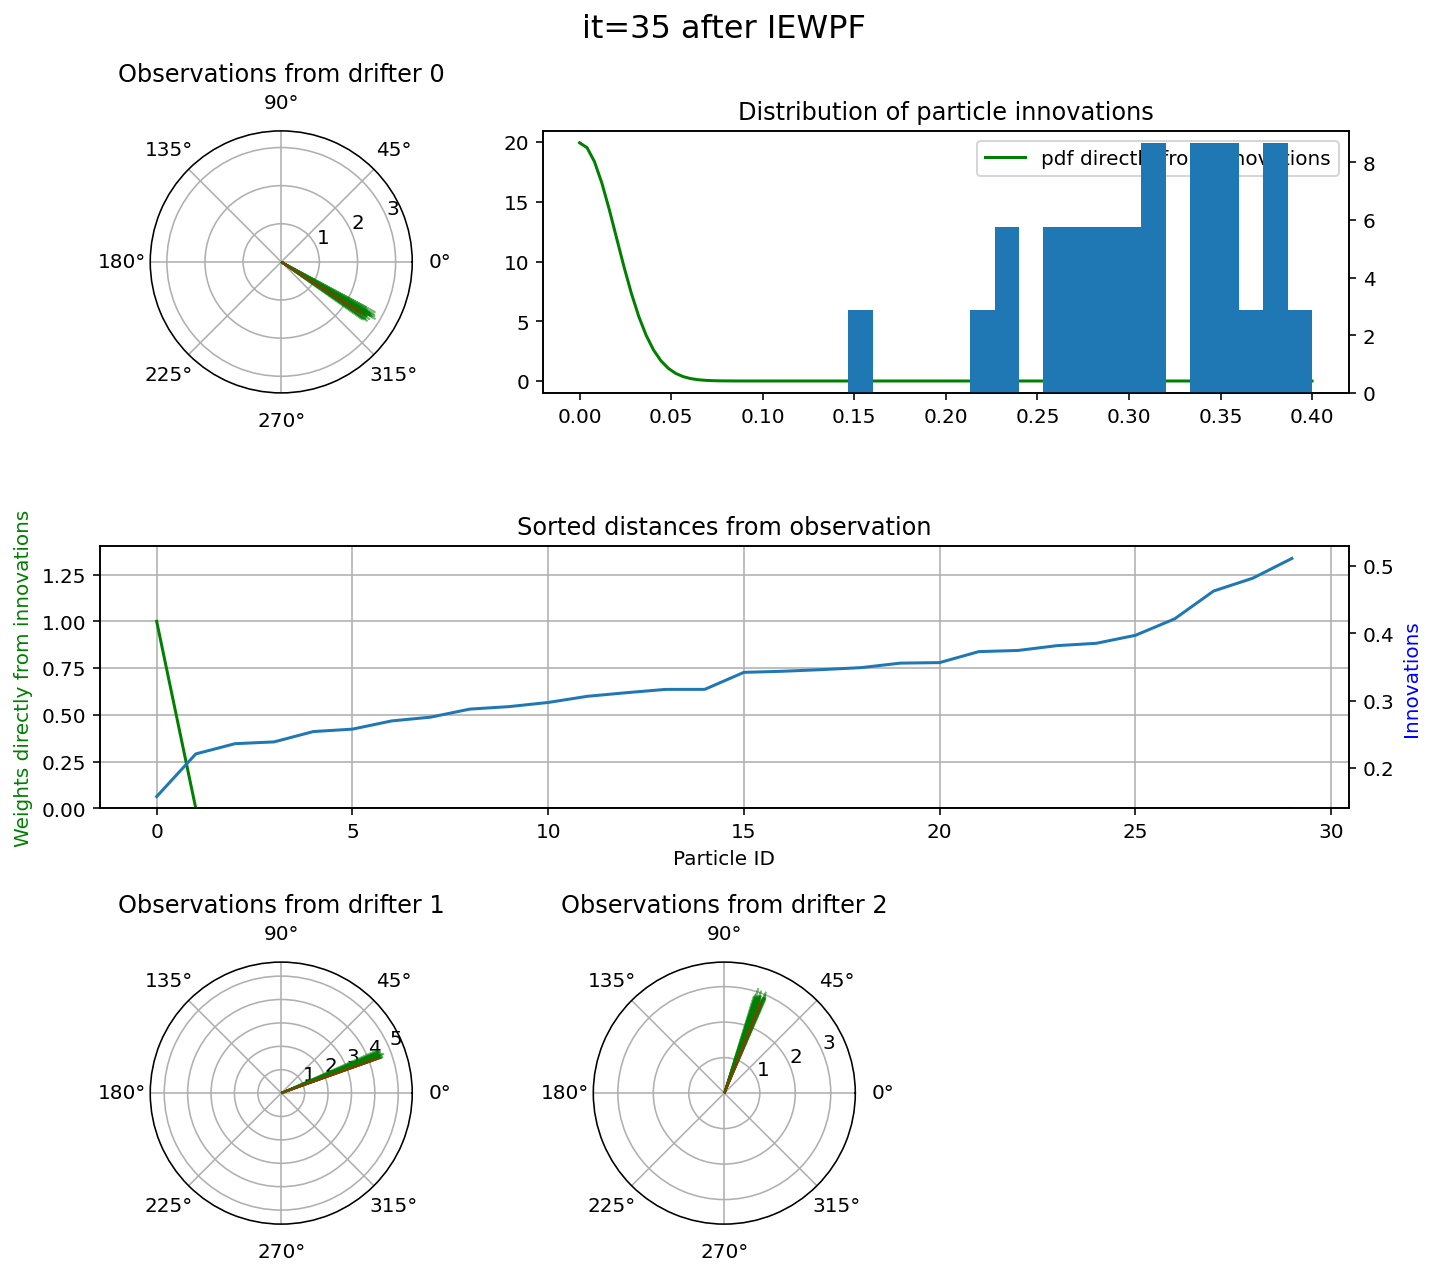

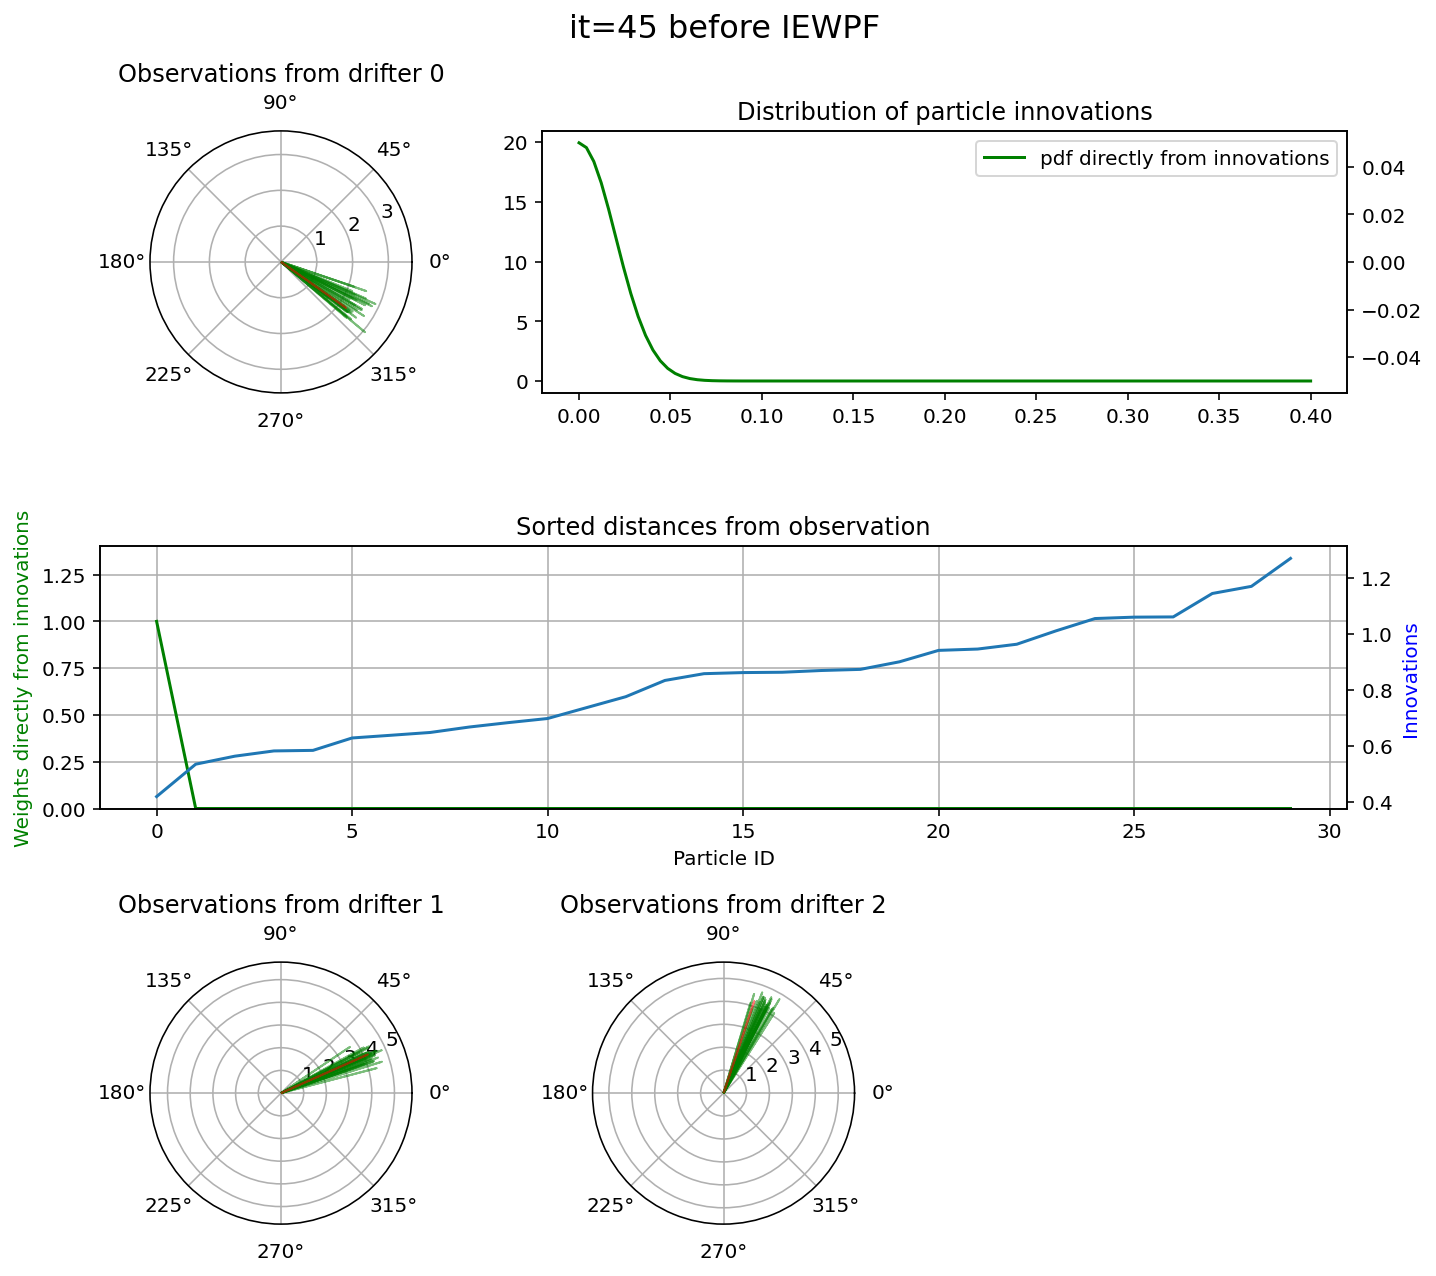

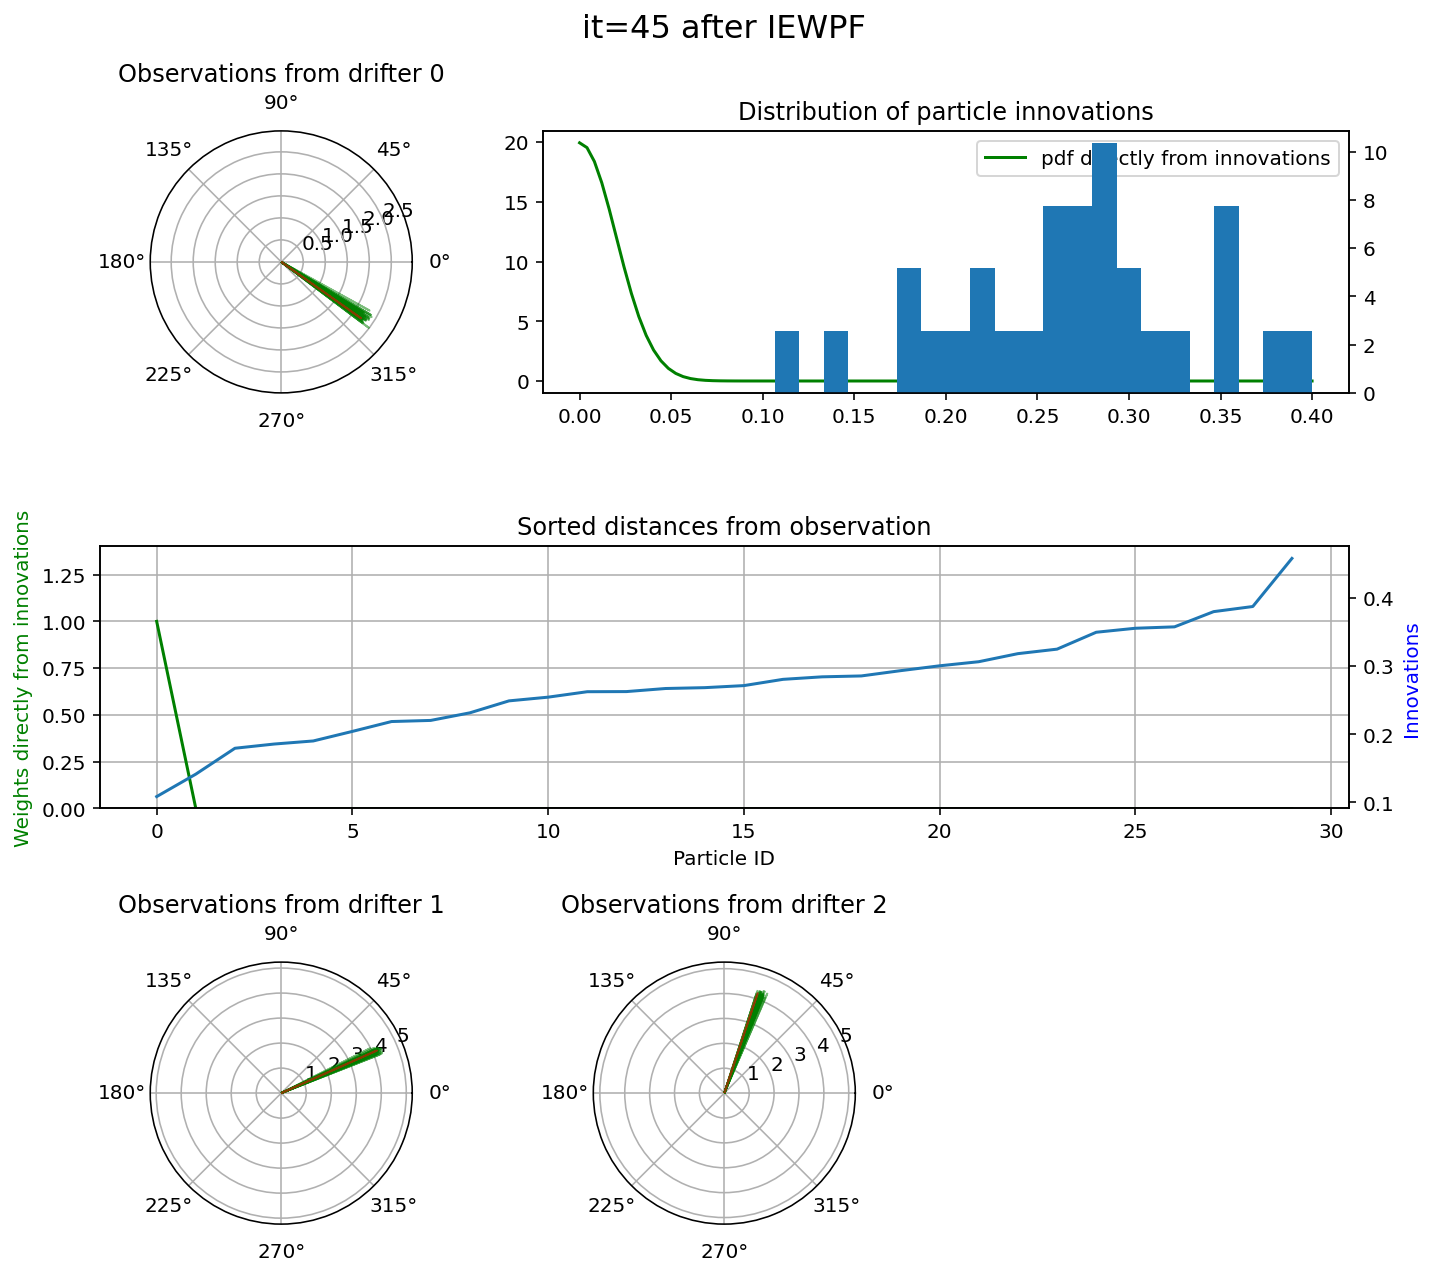

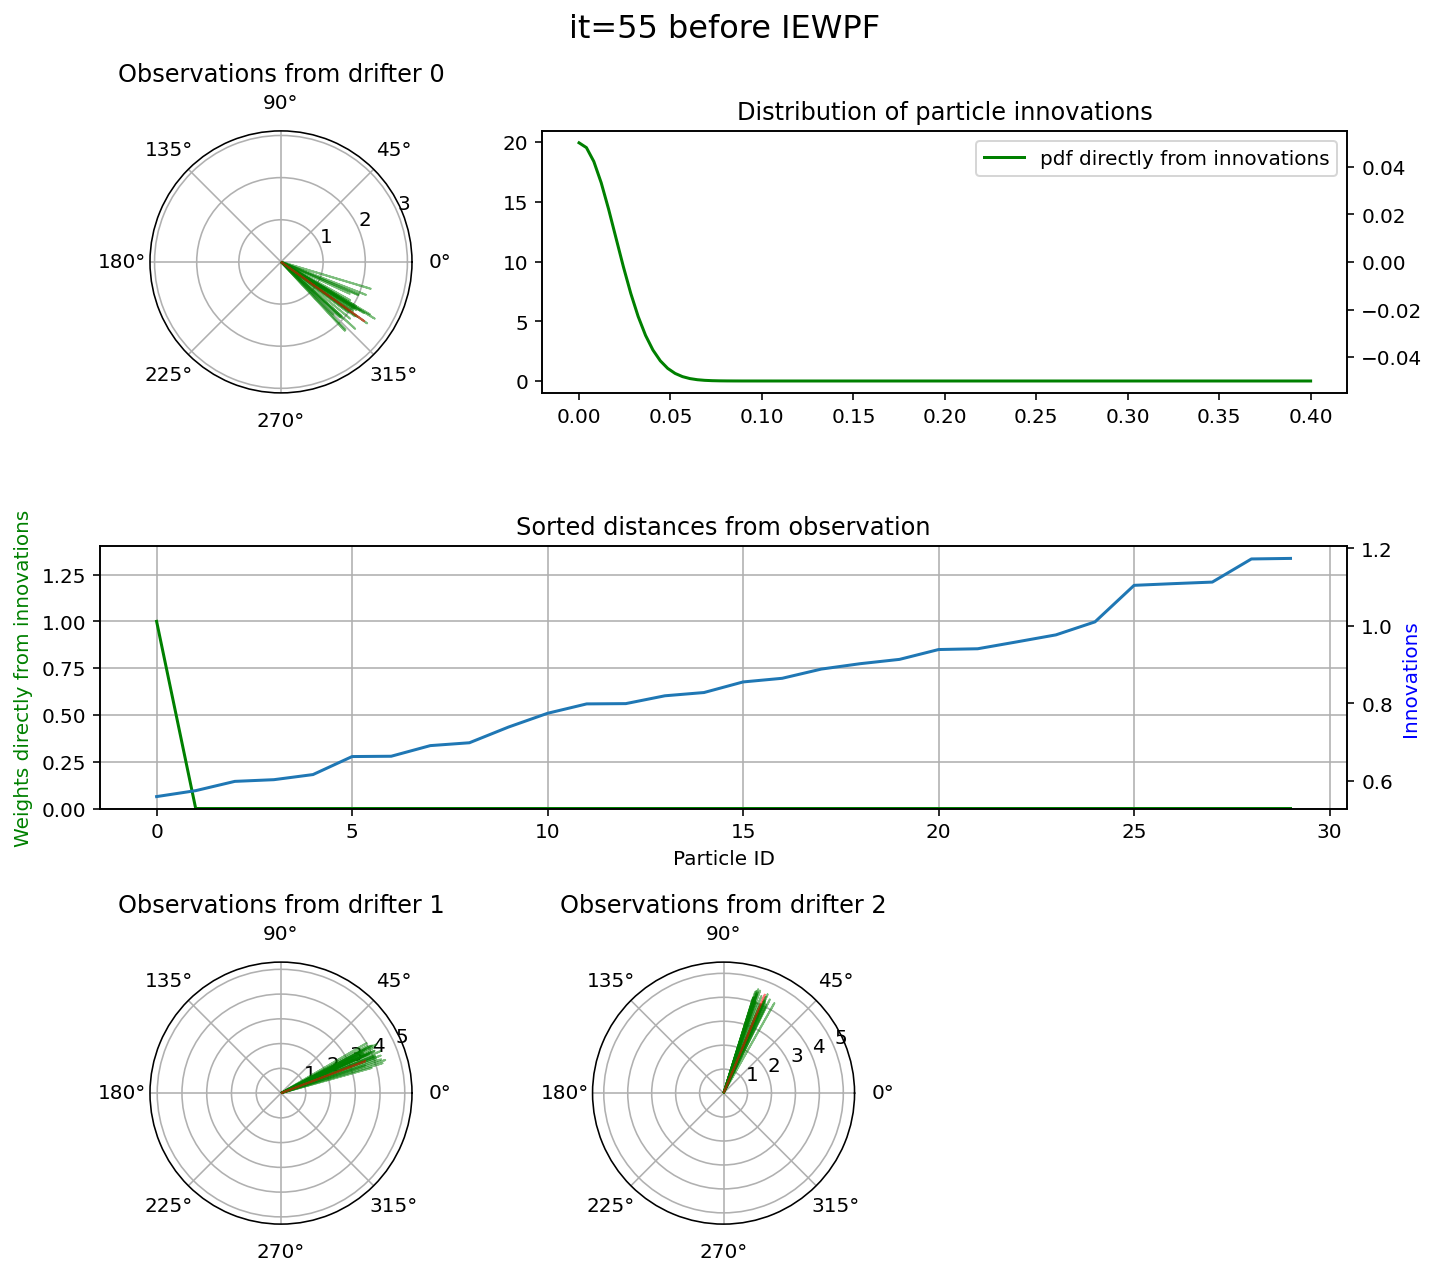

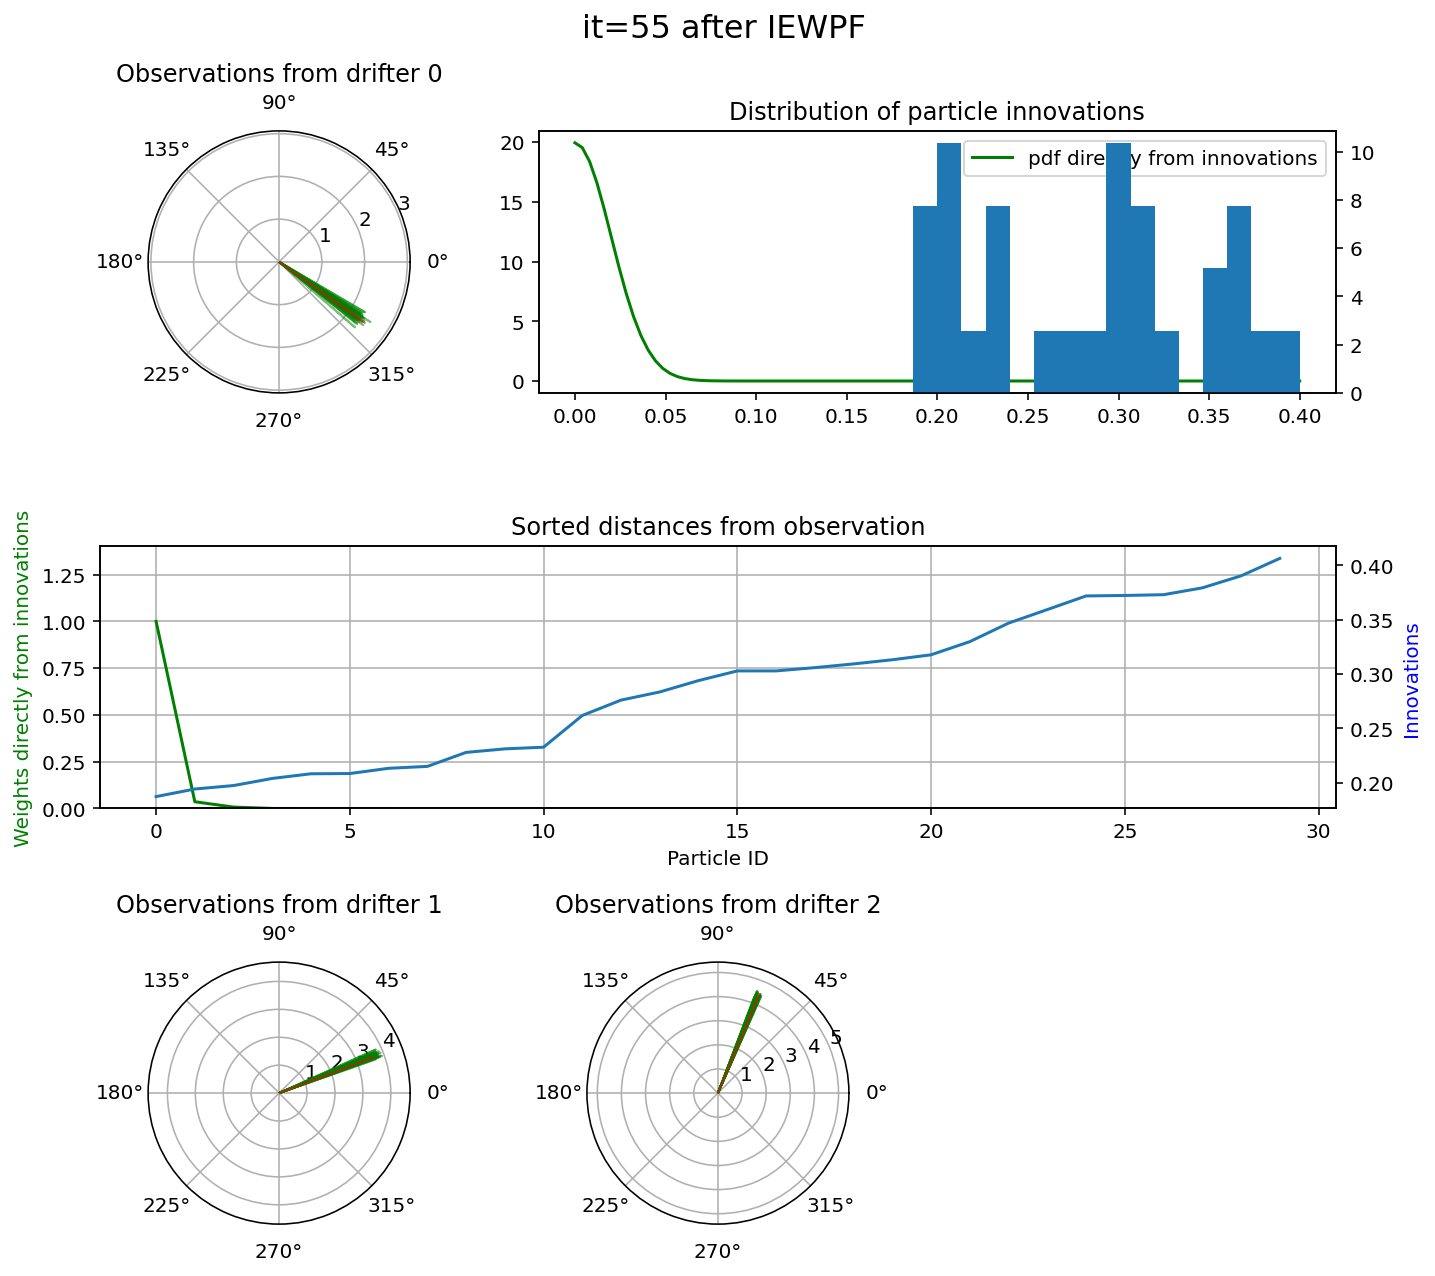

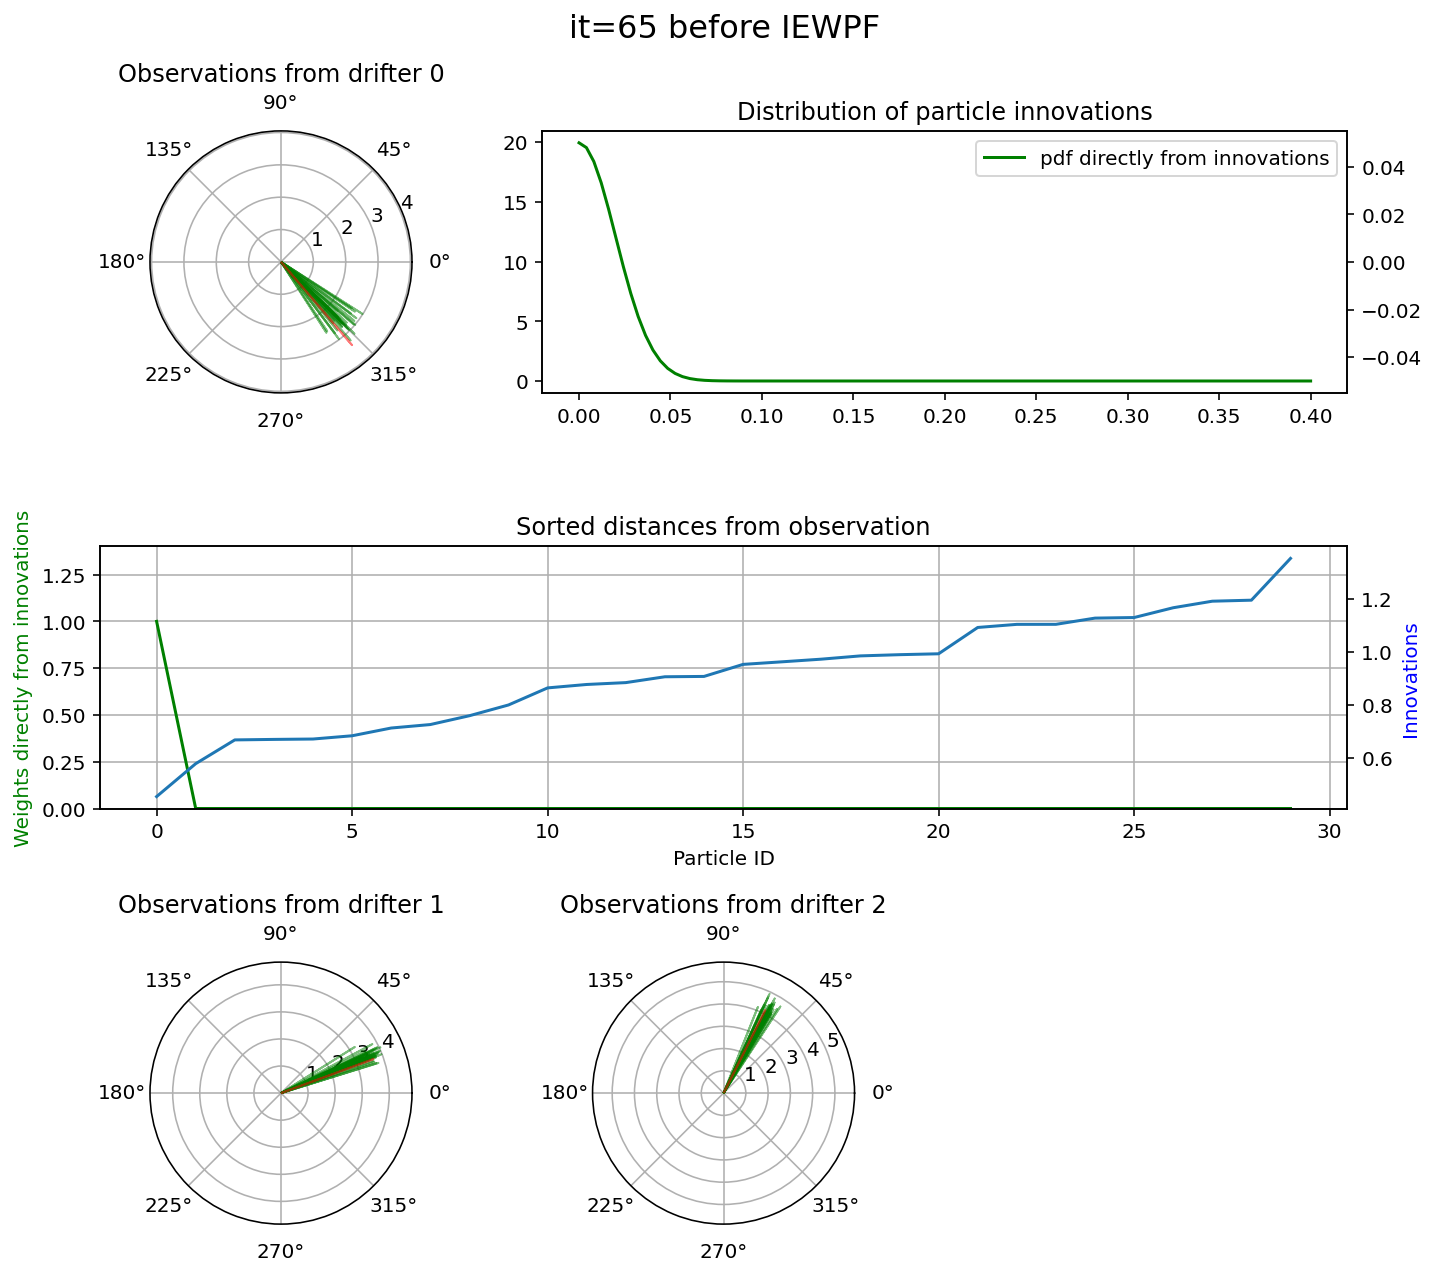

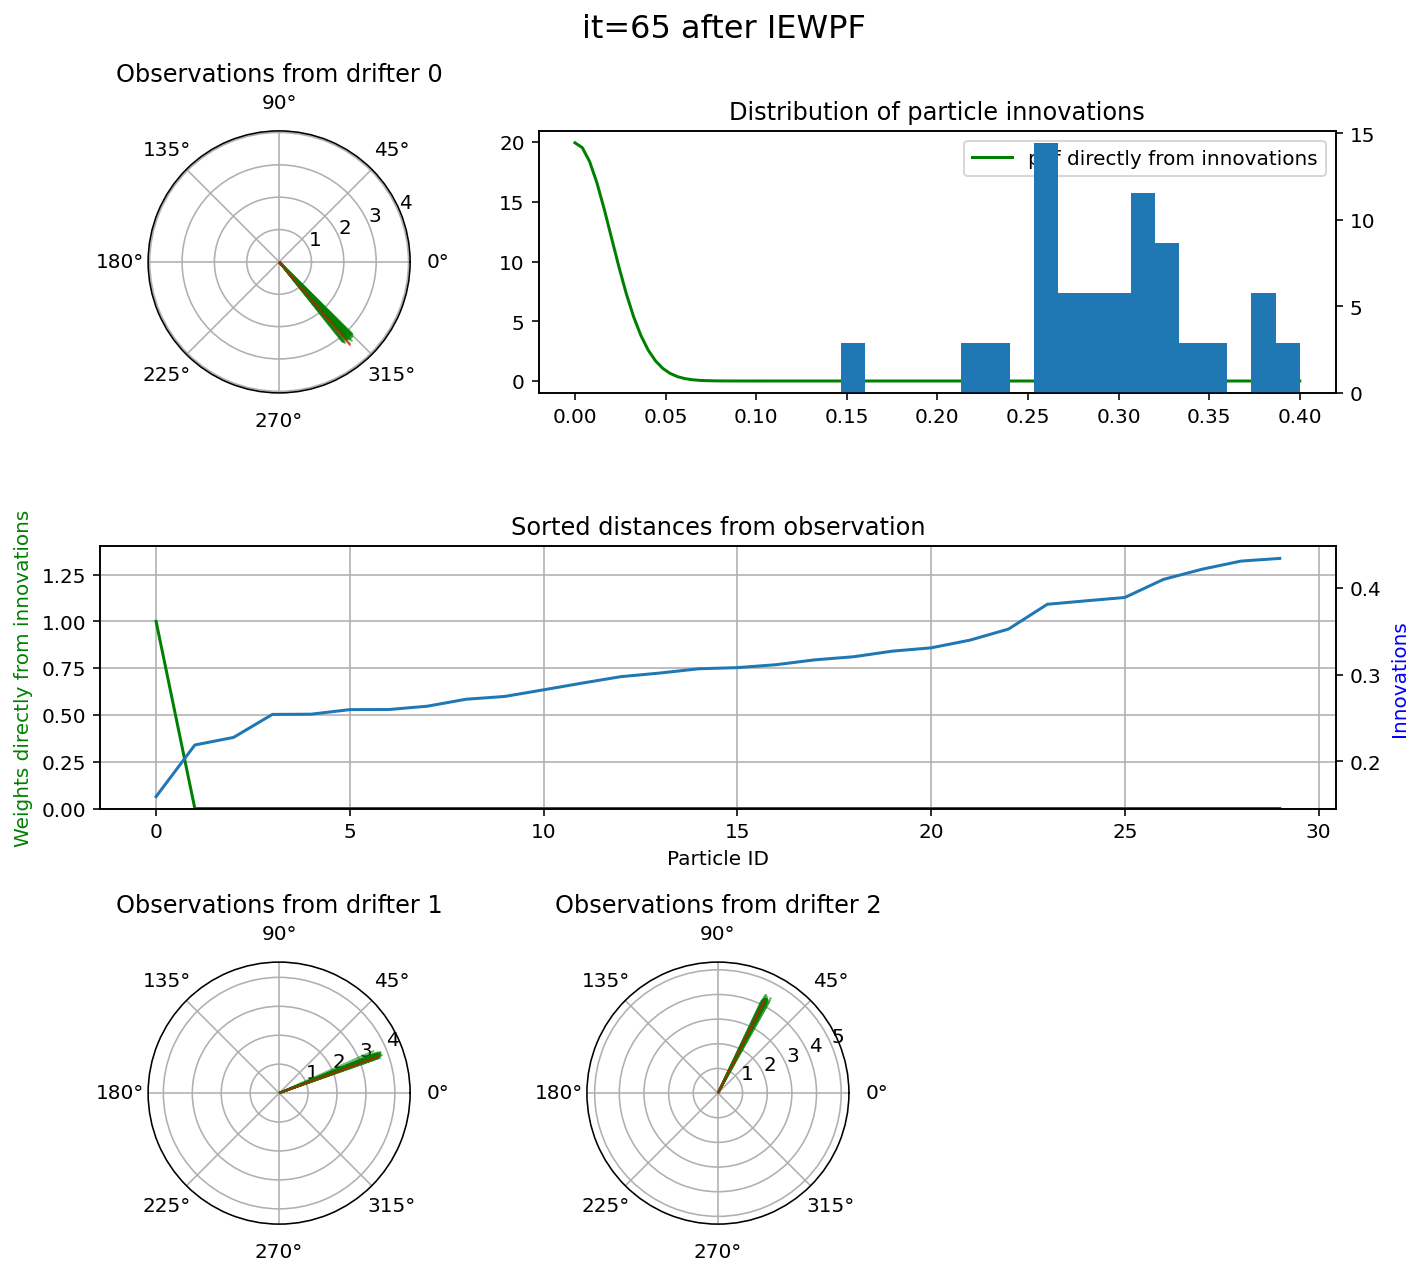

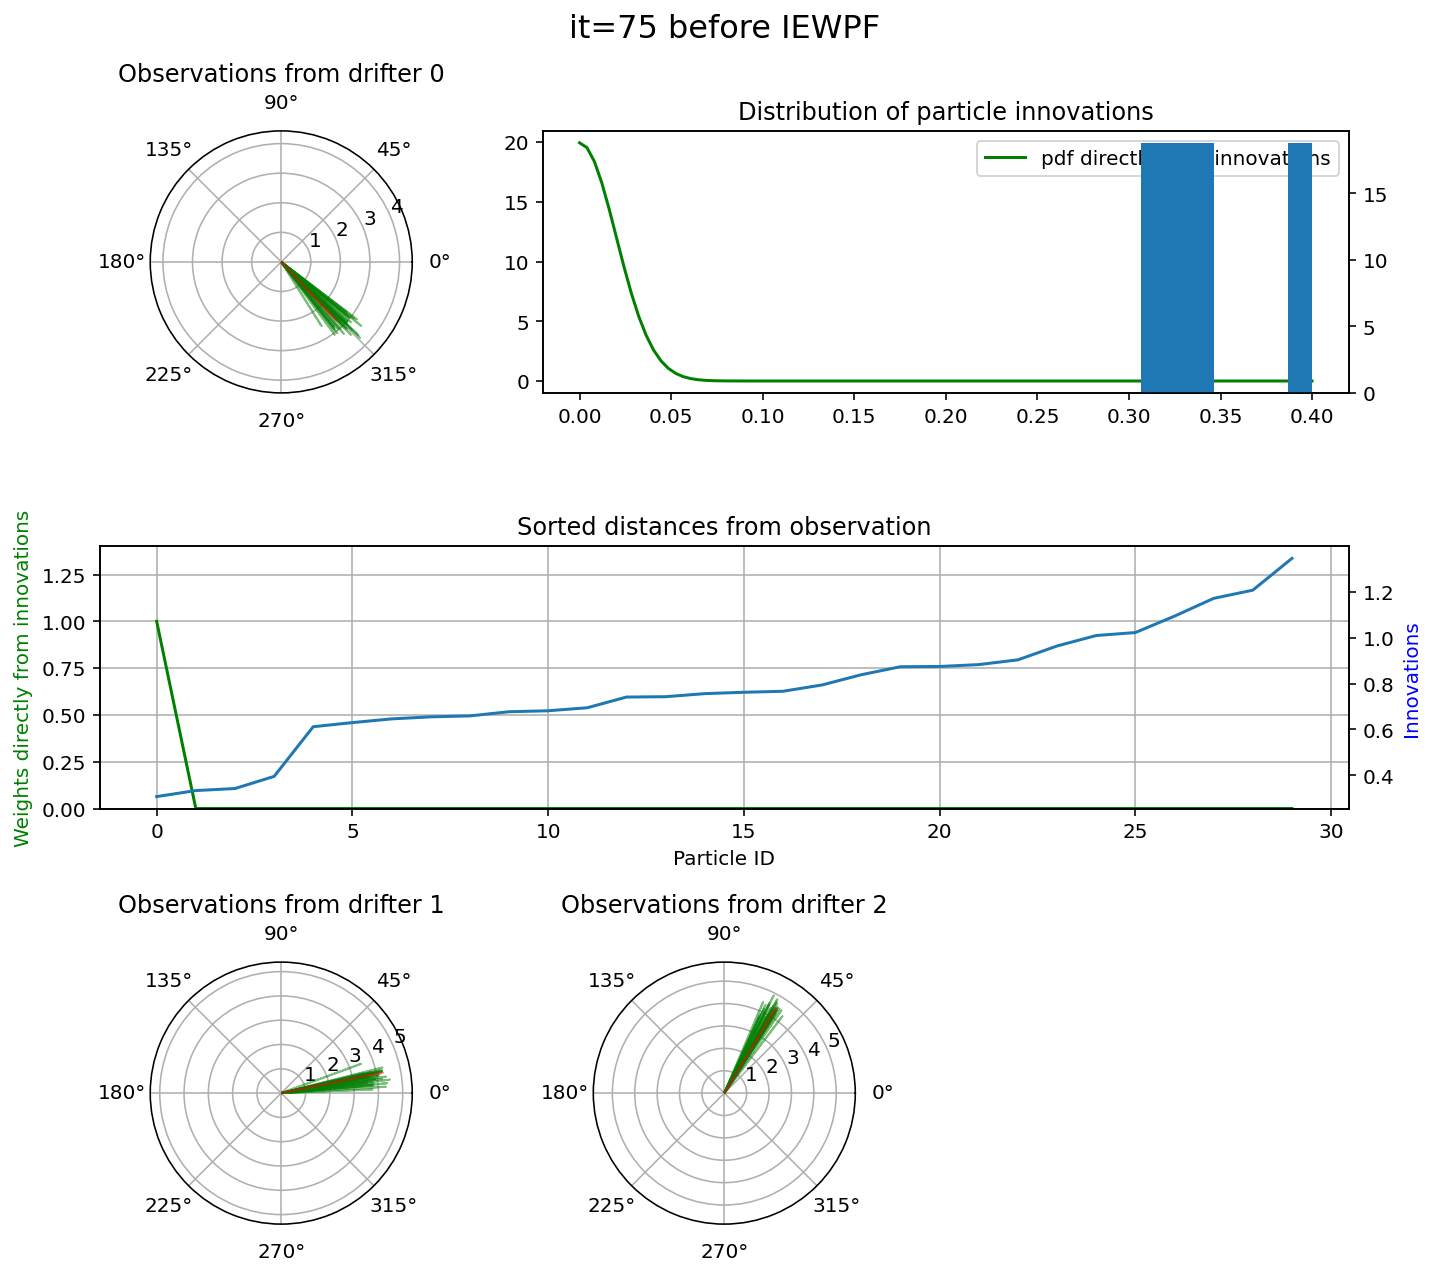

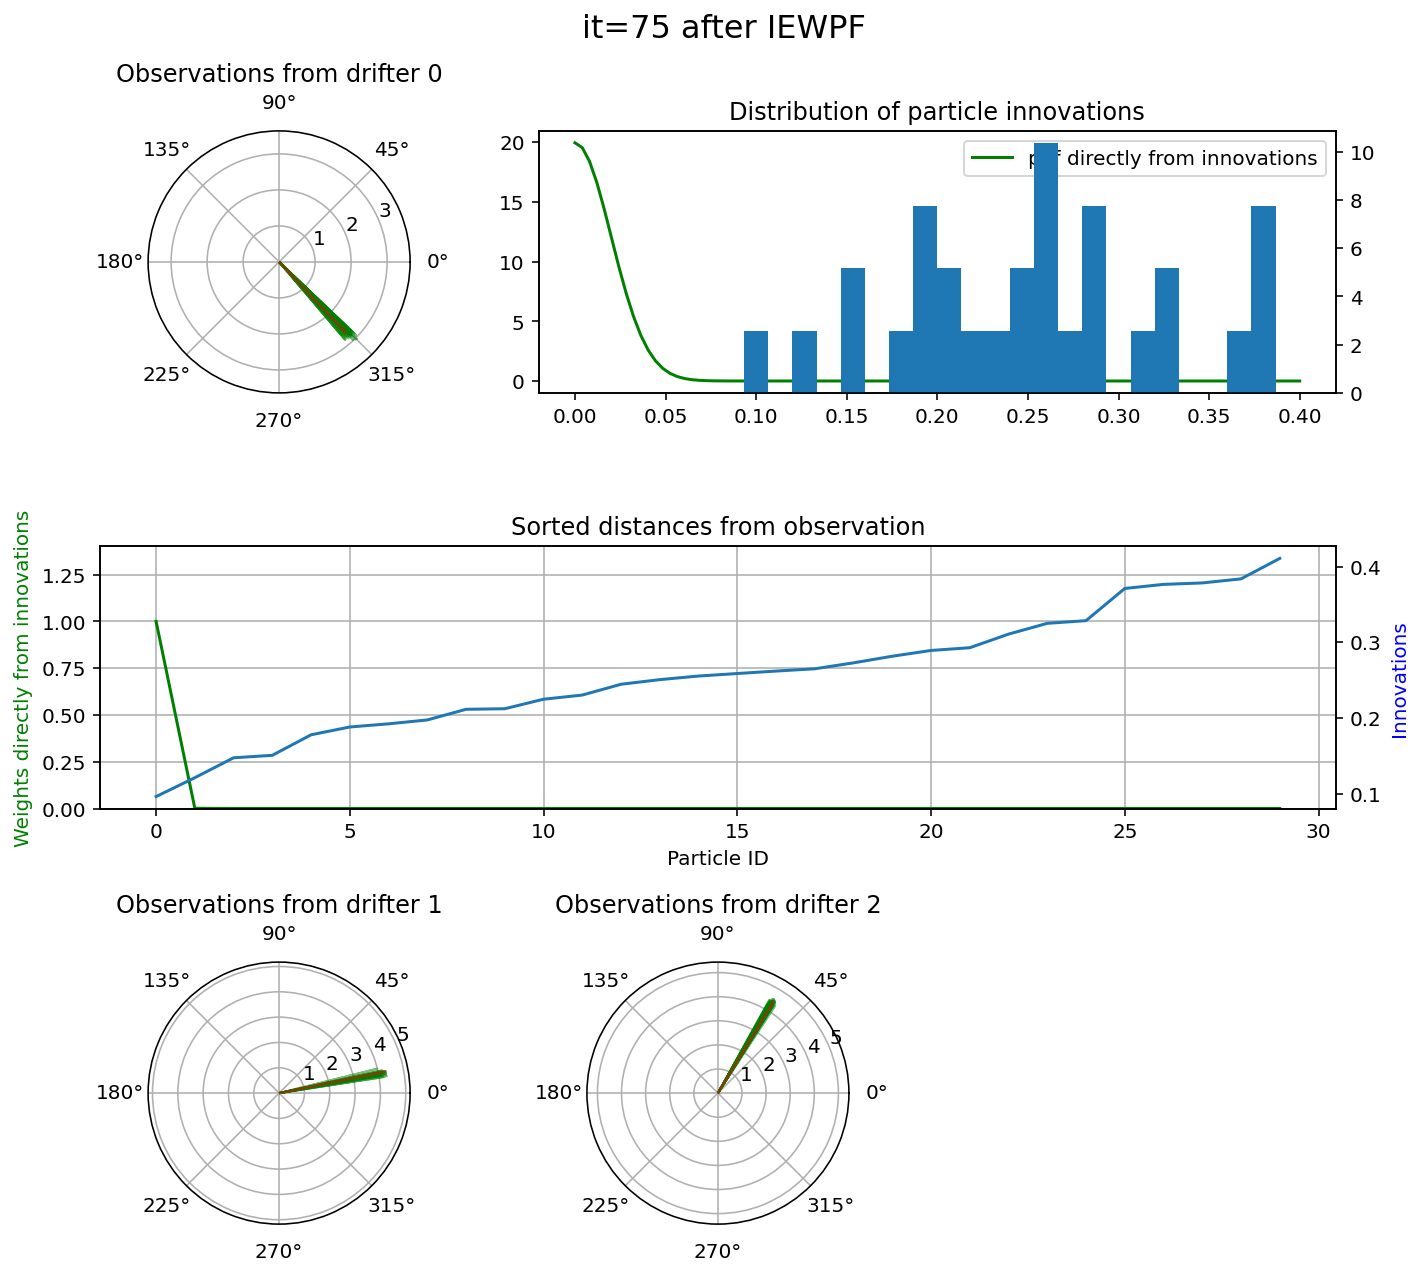

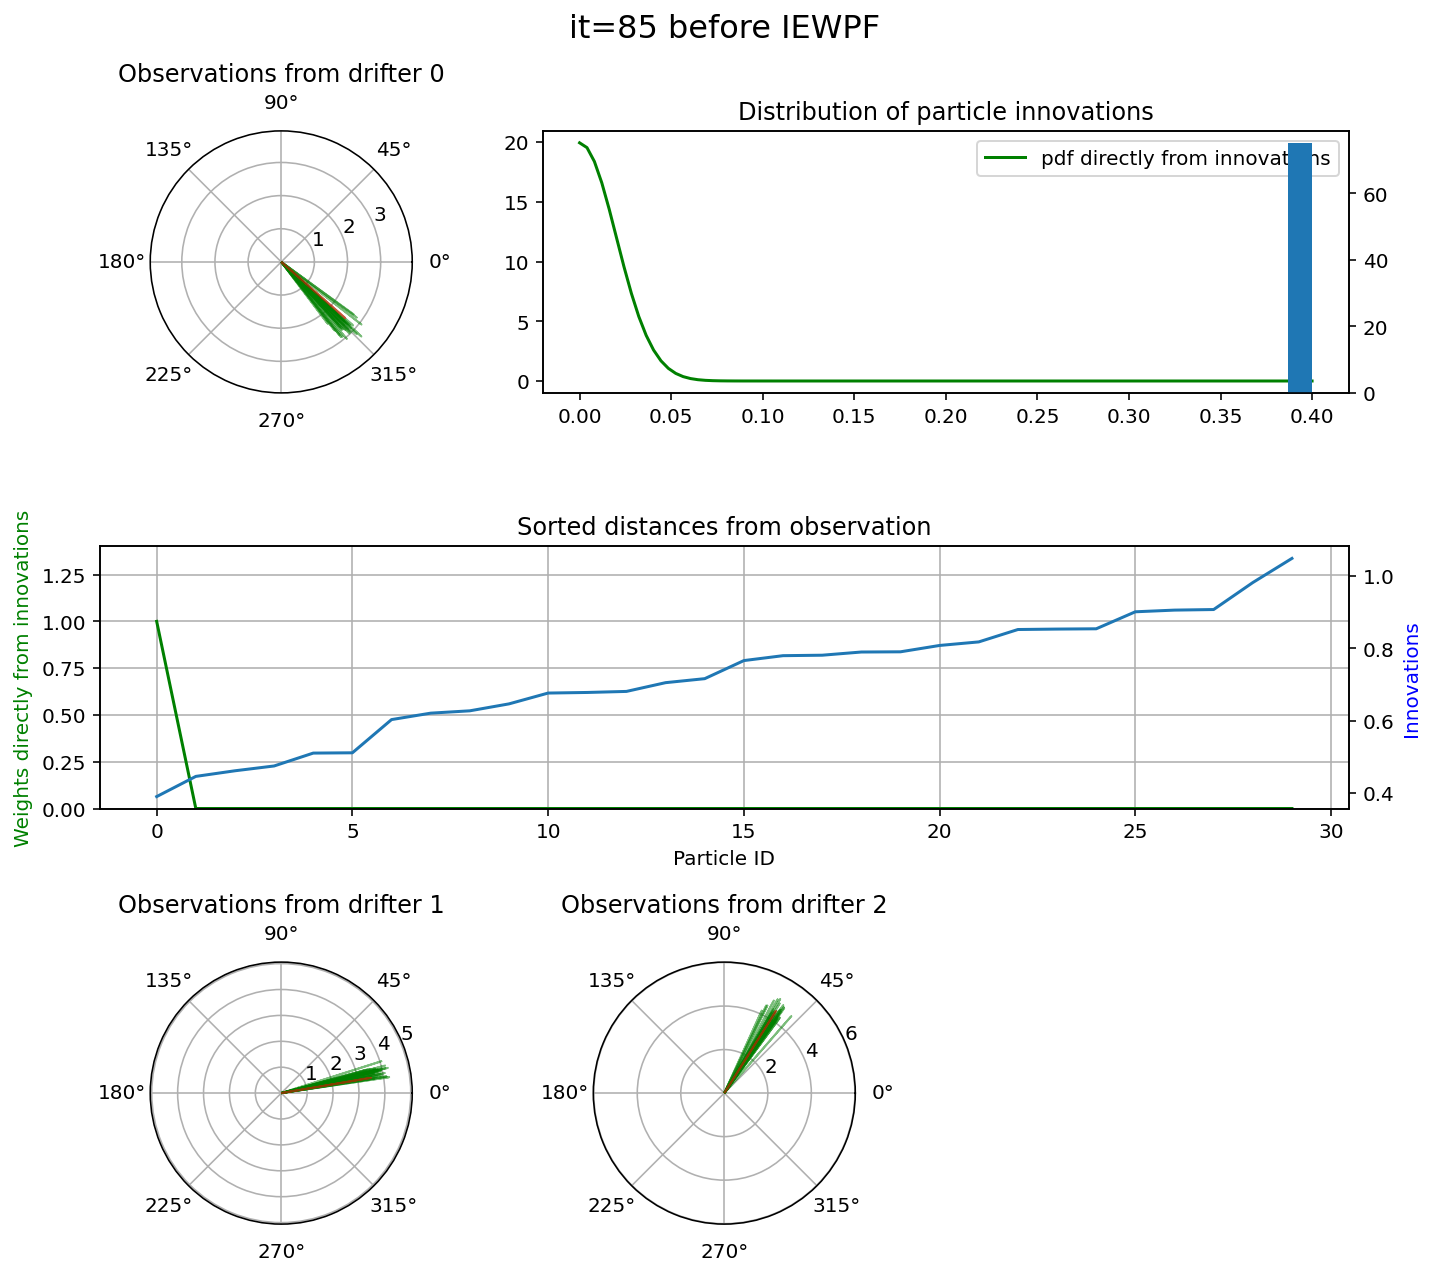

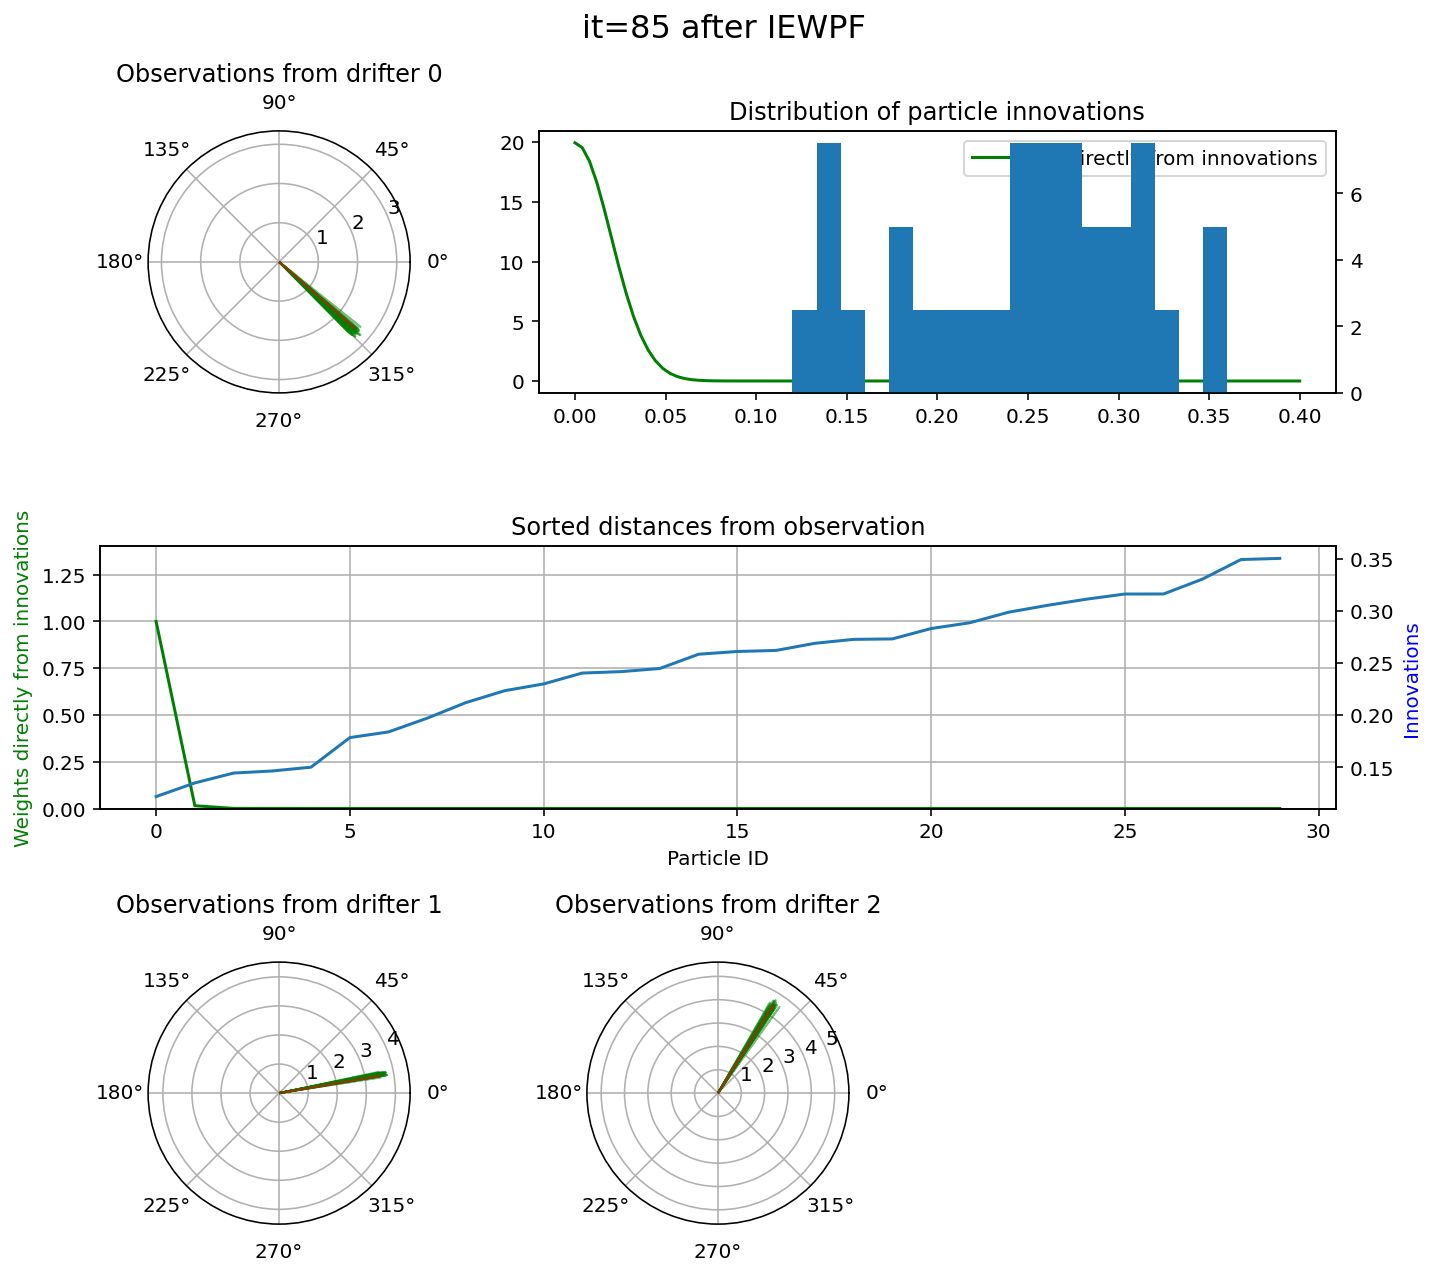

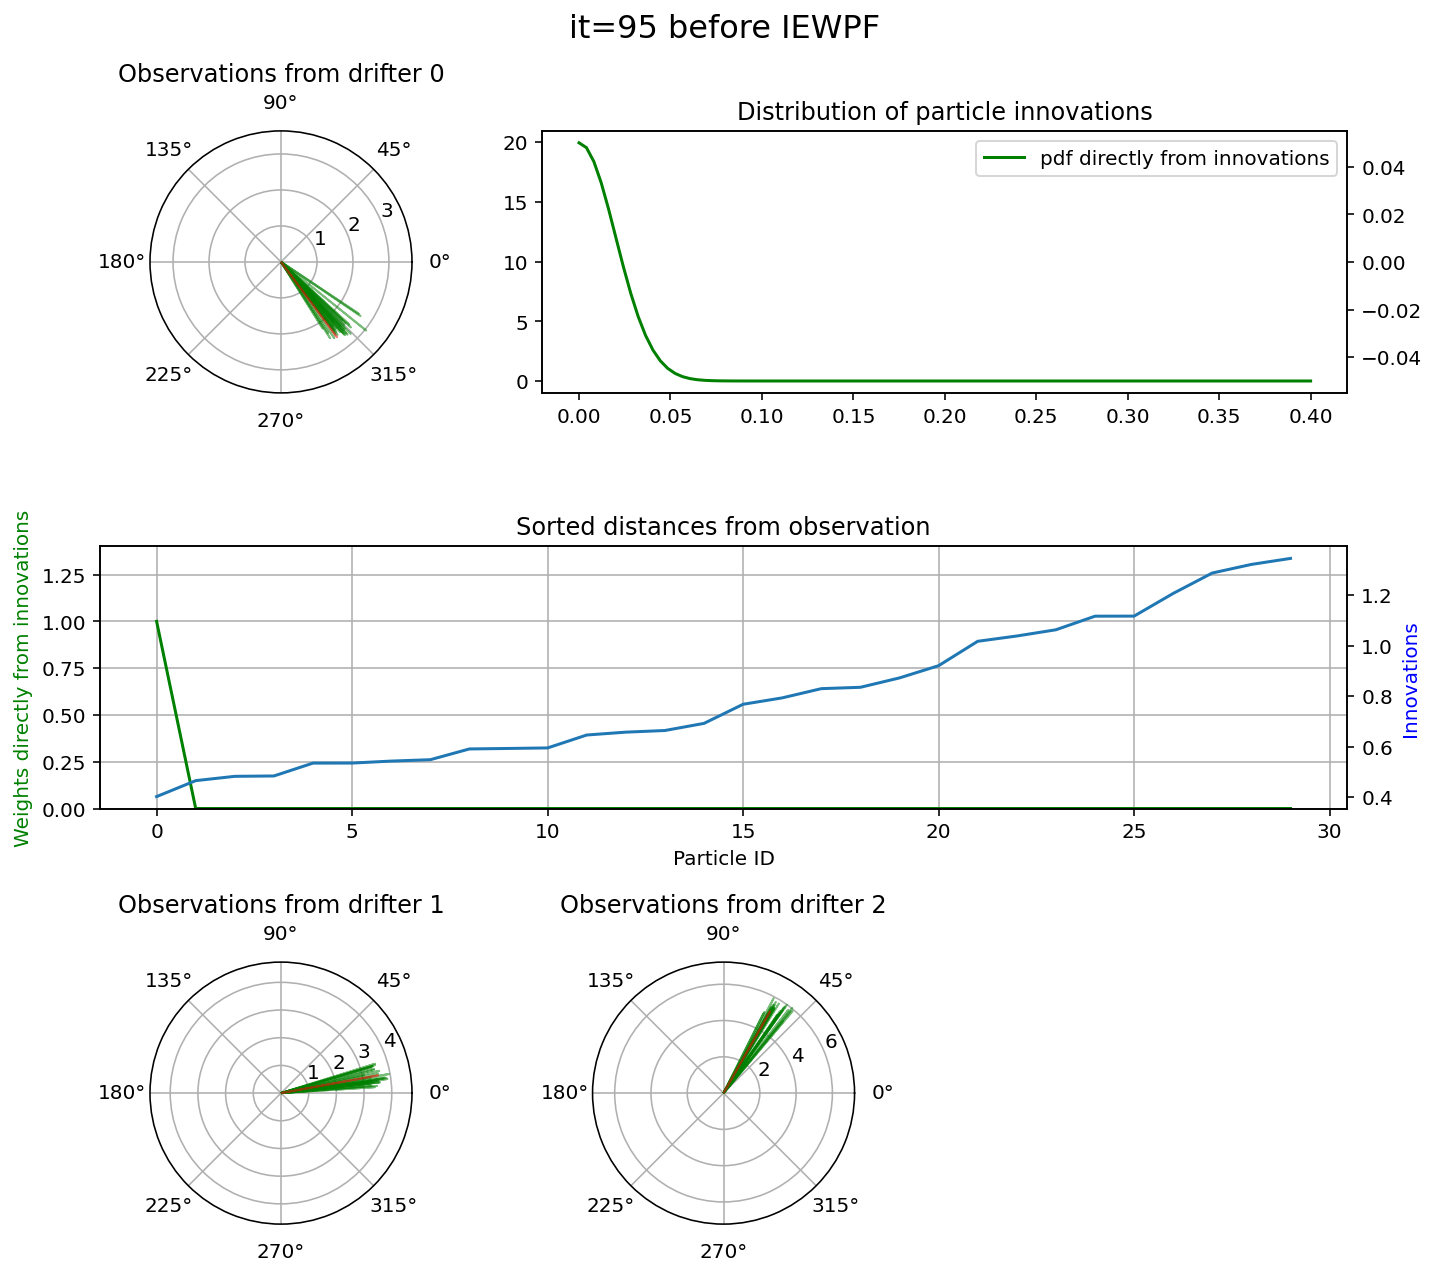

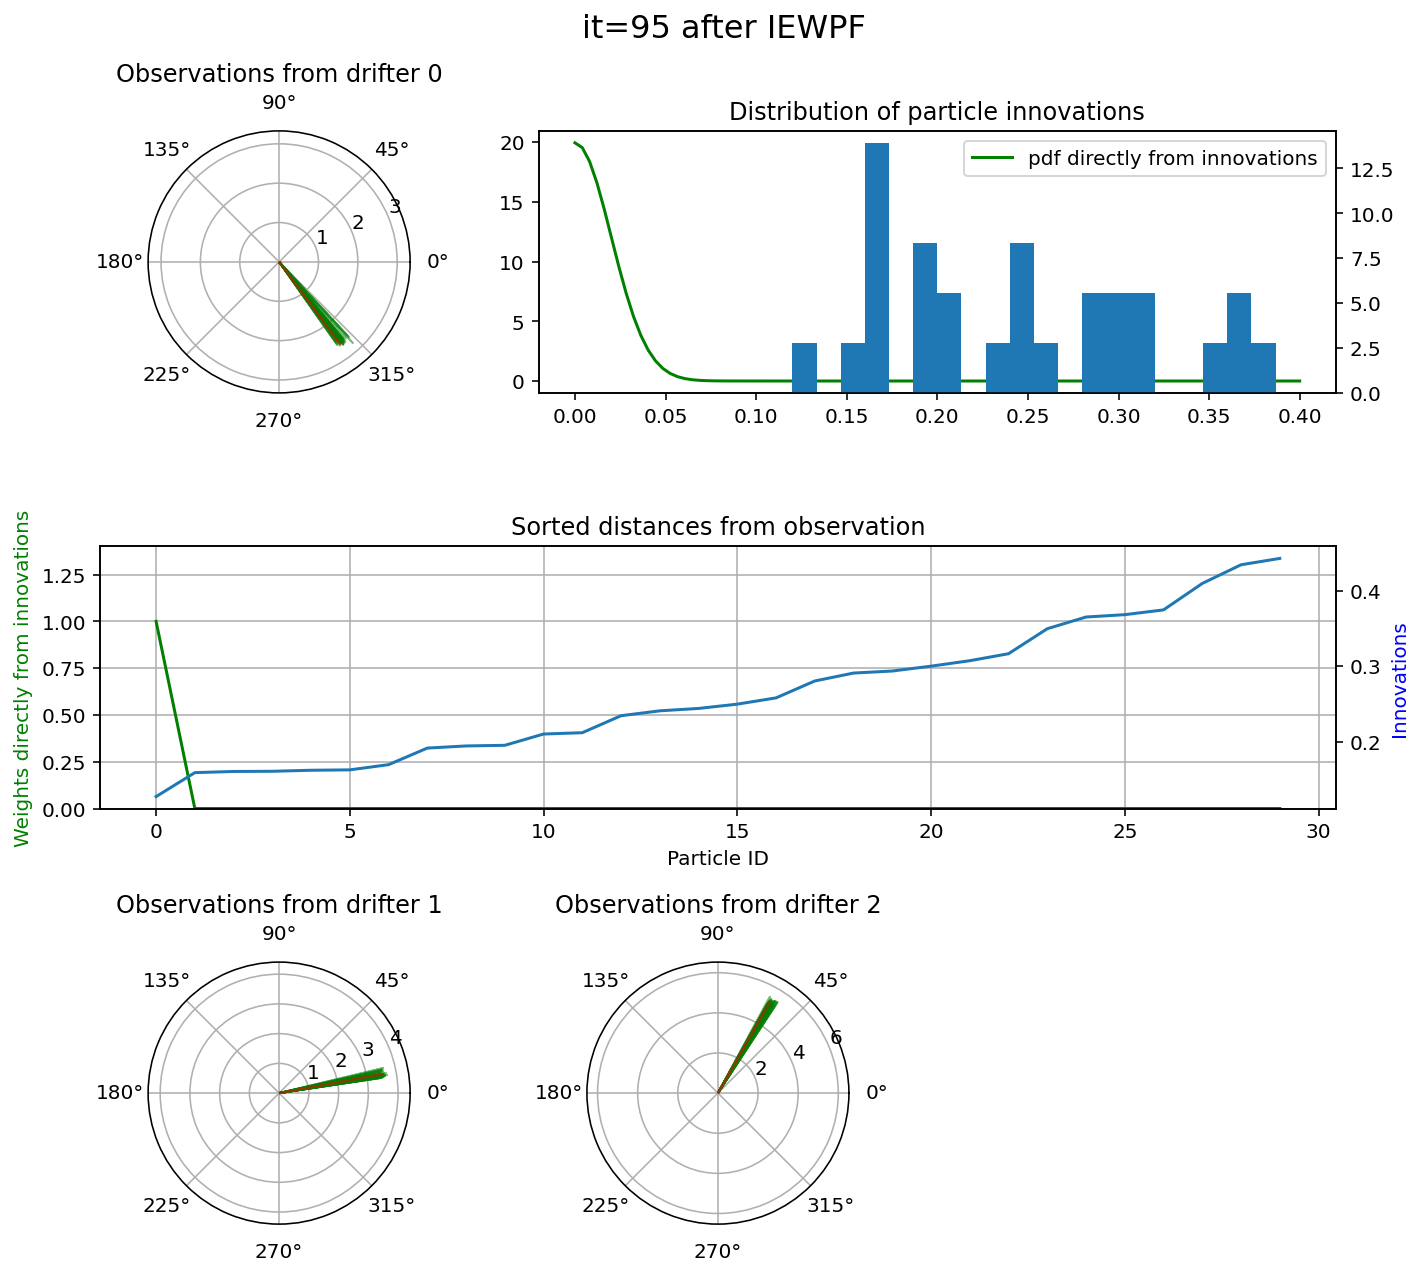

In [5]:
def show_figures(figs):
    for f in figs:
        dummy = plt.figure()
        new_manager = dummy.canvas.manager
        new_manager.canvas.figure = f
        f.set_canvas(new_manager.canvas)
        filename= "iewpf_two_stage_20180720_figures/" + f._suptitle.get_text().replace(" ", "_").replace("=", "_") + ".png"
        print (filename)
        #plt.savefig(filename)
        #plt.close()
show_figures(infoPlots)
#fig = ensemble.plotDistanceInfo(title="Final ensemble")
#ensemble.plotEnsemble()
#plt.savefig("iewpf_20180720_figures/final_ensemble.png")


# Statistical evaluation

In order to check the quality of the particle filter, we investigate the following properties:

Ensemble mean:
$$\bar{\psi} = \frac{1}{N_e}\sum_{i=1}^{N_e} \psi_i$$

Standard deviation of ensemble
$$ \sigma = \sqrt{\frac{ \sum_{i=1}^{N_e} (\psi_i - \bar{\psi})^2}{N_e-1}}$$

Unbaised sample variance
$$s^2 = \frac{1}{n-1} \sum_{i=1}^{N_e} (\psi_i - \bar{\psi})^2$$

Root mean square error, compared to the truth:
$$RMSE_{truth} = \sqrt{(\bar{\psi} - \psi_{truth})^2}$$


Root mean square error, compared to the mean:
$$RMSE_{mean} = \sqrt{\sum_{i=1}^{N_e} \frac{(\psi_i - \bar{\psi})^2}{N_e}}$$


##### What we want:
Compare $\sigma$ with $RMSE_{truth}$.

Average over the domain is the better meassure.

Robust filter: Std.dev slightly larger than RMSE.

### Question
How does the above quantities compare to $q_0$ (the amplitude of the SOAR function)? It is the standard deviation.

Recap, SOAR function given by
$$ Q^{1/2}(a,b) = q_0 \left[ 1 + \frac{dist(a,b)}{L} \right] \exp \left\{ - \frac{dist(a,b)}{L} \right\},$$
and geostrophic balances
$$\delta hu_{j,k} = -\frac{g H_{j,k}}{f} \frac{\delta \eta_{j,k+1} - \delta \eta_{j, k-1}}{2 \Delta y}$$
and
$$ \delta hv_{j,k} = \frac{g H_{j,k}}{f} \frac{\delta \eta_{j+1,k} - \delta\eta_{j-1, k}}{2 \Delta x}. $$

None
None
None
0.02


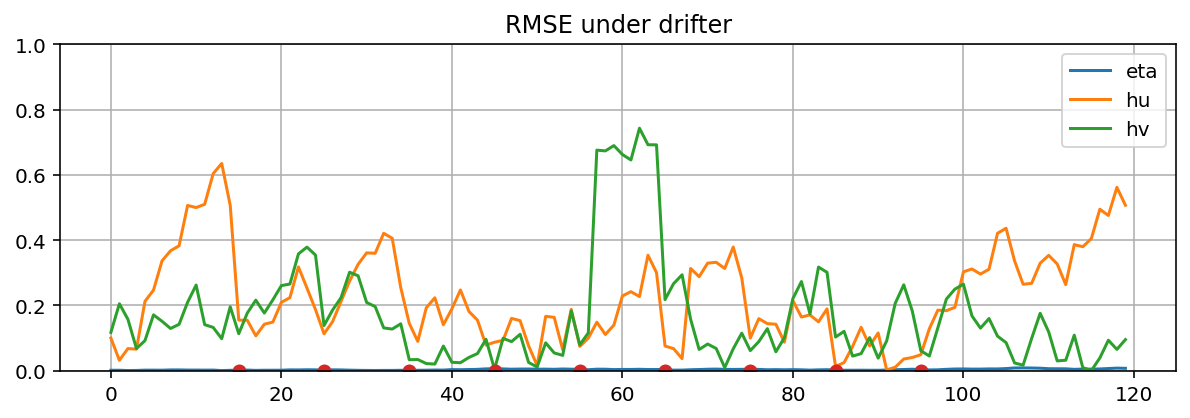

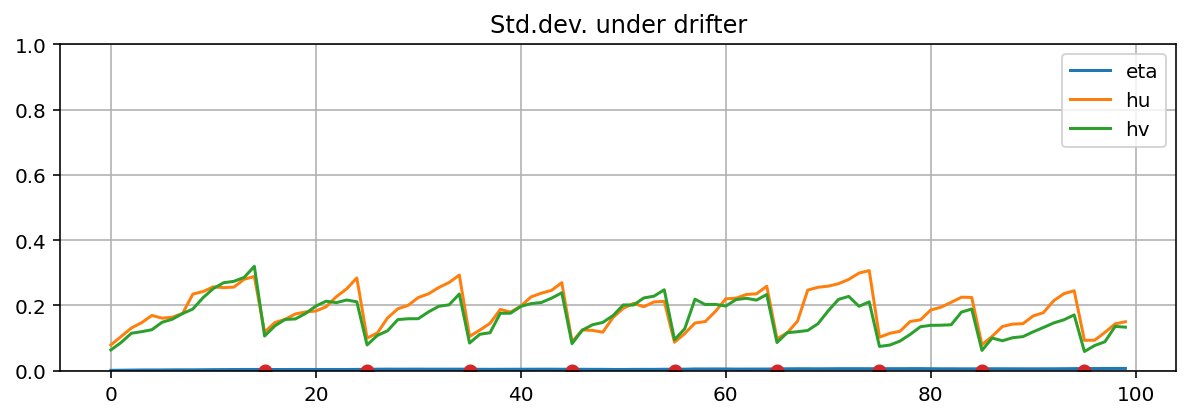

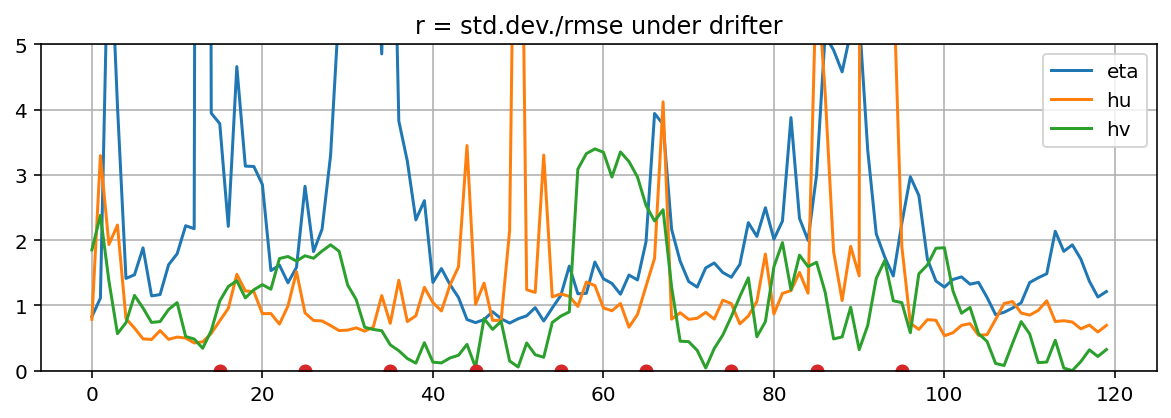

In [6]:
filename = "None"

fig = plt.figure(figsize=(10,3))
plt.plot(ensemble.tArray, ensemble.rmseUnderDrifter_eta, label='eta')
plt.plot(ensemble.tArray, ensemble.rmseUnderDrifter_hu,  label='hu')
plt.plot(ensemble.tArray, ensemble.rmseUnderDrifter_hv,  label='hv')
plt.plot(observation_iterations, 0.0*np.ones_like(observation_iterations), 'o')
plt.title("RMSE under drifter")
plt.legend(loc=0)
plt.grid()
plt.ylim([0, 1])
#filename= "iewpf_20180720_figures/RMSE_under_drifter.png"
print (filename)
#plt.savefig(filename)

fig = plt.figure(figsize=(10,3))
plt.plot(ensemble.tArray[:100], ensemble.varianceUnderDrifter_eta[:100], label='eta')
plt.plot(ensemble.tArray[:100], ensemble.varianceUnderDrifter_hu[:100],  label='hu')
plt.plot(ensemble.tArray[:100], ensemble.varianceUnderDrifter_hv[:100],  label='hv')
plt.plot(observation_iterations, 0.0*np.ones_like(observation_iterations), 'o')
plt.title("Std.dev. under drifter")
plt.legend(loc=0)
plt.grid()
plt.ylim([0, 1
         ])
#filename= "iewpf_20180720_figures/var_under_drifter.png"
print (filename)
#plt.savefig(filename)

fig = plt.figure(figsize=(10,3))
plt.plot(ensemble.tArray, ensemble.rUnderDrifter_eta, label='eta')
plt.plot(ensemble.tArray, ensemble.rUnderDrifter_hu,  label='hu')
plt.plot(ensemble.tArray, 1.0/np.array(ensemble.rUnderDrifter_hv),  label='hv')
plt.plot(observation_iterations, 0.0*np.ones_like(observation_iterations), 'o')
plt.title("r = std.dev./rmse under drifter")
plt.legend(loc=0)
plt.grid()
plt.ylim([0, 5])
#filename= "iewpf_20180720_figures/r_under_drifter.png"
print (filename)
#plt.savefig(filename)

print (np.sqrt(ensemble.observation_cov[0,0]))

In [7]:


print( ensemble.getObservationVariance())
print( np.sqrt(ensemble.getObservationVariance()))

print( ensemble.small_scale_perturbation_amplitude)

0.0004
0.02
0.00017095321


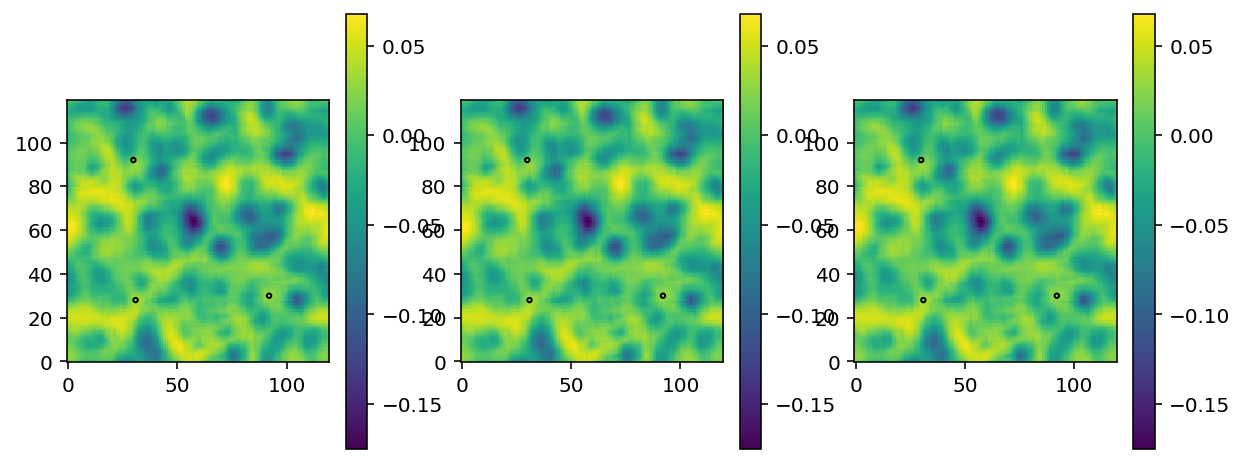

In [8]:
eta, hu, hv = ensemble.particles[0].download(interior_domain_only=True)

fig = plt.figure(figsize=(10,4))

ax1 = plt.subplot(1,3,1)
plt.imshow(eta, origin="lower", interpolation="None")
plt.colorbar()

ax2 = plt.subplot(1,3,2)
plt.imshow(eta, origin="lower", interpolation="None")
plt.colorbar()

ax3 = plt.subplot(1,3,3)
plt.imshow(eta, origin="lower", interpolation="None")
plt.colorbar()

observed_drifter_positions = ensemble.observeTrueDrifters()
EnsemblePlot._markDriftersInImshow(ax1, ensemble, observed_drifter_positions)
EnsemblePlot._markDriftersInImshow(ax2, ensemble, observed_drifter_positions)
EnsemblePlot._markDriftersInImshow(ax3, ensemble, observed_drifter_positions)


# Stepping through one iteration with one ocean state

In [9]:
# Utility plotter function
def imshow3(eta, hu, hv, interpolation="None", title=None, interior=False):
    fig, axs = plt.subplots(1,3, figsize=(12,4))
    
    if interior:
        eta_im = axs[0].imshow(eta[2:-2,2:-2], interpolation=interpolation, origin='lower')
    else:
        eta_im = axs[0].imshow(eta, interpolation=interpolation, origin='lower')
    axs[0].set_title("eta")
    plt.colorbar(eta_im, ax=axs[0])
    
    if interior:
        hu_im = axs[1].imshow(hu[2:-2,2:-2], interpolation=interpolation, origin='lower')
    else:
        hu_im = axs[1].imshow(hu, interpolation=interpolation, origin='lower')
    axs[1].set_title("hu")
    plt.colorbar(hu_im, ax=axs[1])

    if interior:
        hv_im = axs[2].imshow(hv[2:-2,2:-2], interpolation=interpolation, origin='lower')
    else:
        hv_im = axs[2].imshow(hv, interpolation=interpolation, origin='lower')
    axs[2].set_title("hv")
    plt.colorbar(hv_im, ax=axs[2])

    if title is not None:
        plt.suptitle(title)
    plt.tight_layout()

In [10]:
if 'sim' in globals():
    sim.cleanUp()
if 'ensemble' in globals():
    ensemble.cleanUp()
if 'iewpfOcean' in globals():
    iewpfOcean.cleanUp()


reload(OceanStateNoise)
reload(CDKLM16)
reload(BaseOceanStateEnsemble)
reload(OceanNoiseEnsemble)
reload(PlotHelper)
reload(dautils)
reload(IEWPFOcean)


# Create a new ensemble with an initial perturbation
sim = CDKLM16.CDKLM16(**sim_args)
sim.perturbState(q0_scale=100)

ensemble_args["numParticles"] = 5
ensemble_args["num_drifters"] = 3
ensemble_args["sim"] = sim
ensemble = OceanNoiseEnsemble.OceanNoiseEnsemble(**ensemble_args)

iewpfOcean = IEWPFOcean.IEWPFOcean(ensemble, debug=False, show_errors=True)

# Ensuring that the particles behave a bit different from each others
ensemble.step(100*ensemble.dt)

# Set the state of particle 0 to zero 
zeros = np.zeros((ensemble.ny+4, ensemble.nx+4), dtype=np.float32)
ensemble.particles[0].gpu_data.h0.upload(ensemble.particles[0].gpu_stream, zeros)
ensemble.particles[0].gpu_data.hu0.upload(ensemble.particles[0].gpu_stream, zeros)
ensemble.particles[0].gpu_data.hv0.upload(ensemble.particles[0].gpu_stream, zeros)


# Plot
#ensemble.plotEnsemble(num_particles=2)
print("ready")

ready


The initial steps of IEWPF before looping through particles

In [11]:
# Observe true drifter positions and get innovations
observed_drifter_positions = ensemble.observeTrueDrifters()
print("observed drifter positions: ", observed_drifter_positions)

# Innovations
innovations = ensemble.getInnovations()
print("Innovations: ", innovations)

# Get the weights before resampling - all equal, so we only make a scalar (instead of a vector)
w_rest = -np.log(1.0/ensemble.getNumParticles())*np.ones(ensemble.getNumParticles())
print("w_rest: ", w_rest)

phi_array     = np.zeros(ensemble.getNumParticles())
nu_norm_array = np.zeros(ensemble.getNumParticles())
gamma_array   = np.zeros(ensemble.getNumParticles())

observed drifter positions:  [[119.524704 116.811134]
 [361.96442  119.49402 ]
 [119.993835 360.24063 ]]
Innovations:  [[[-0.66680992 -6.69282532]
  [ 2.93027592 -2.20575809]
  [-0.98362046  3.65240026]]

 [[-0.78624806  0.40242606]
  [ 0.3913909  -0.58203267]
  [ 0.73605604  0.62779534]]

 [[ 0.4036077  -0.02146334]
  [ 0.00869323 -0.18368841]
  [ 0.26144324  0.60207203]]

 [[-0.33783304 -0.3223995 ]
  [-0.46216614 -0.37917466]
  [ 0.05878771  0.23306425]]

 [[-0.01913619  0.05871745]
  [ 0.22787034 -0.08817441]
  [ 0.32239699  0.54136537]]]
w_rest:  [1.60943791 1.60943791 1.60943791 1.60943791 1.60943791]


Now we start working with the individual particles. First, we add **the Kalman gain**

phi:  [59680.30826965     0.             0.             0.
     0.        ]


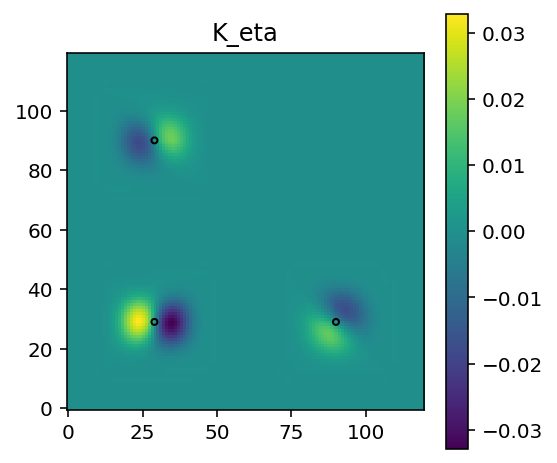

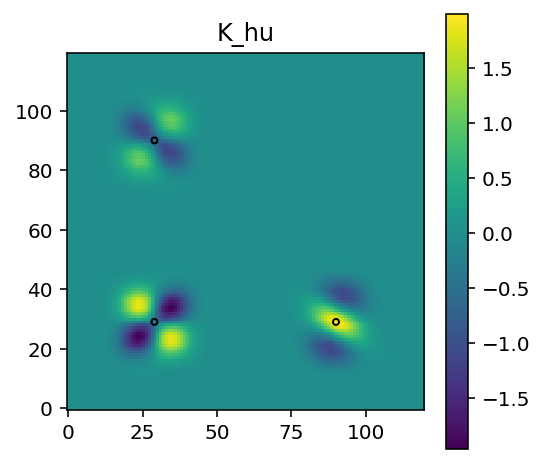

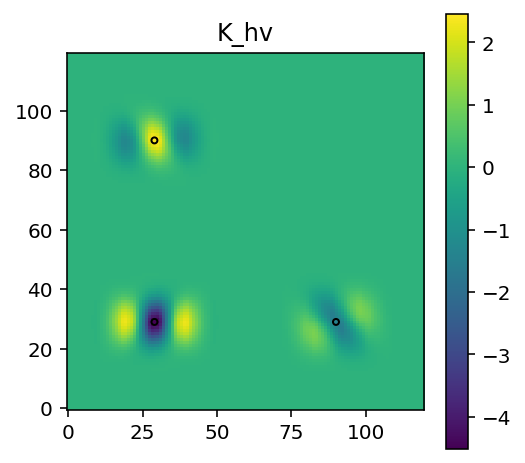

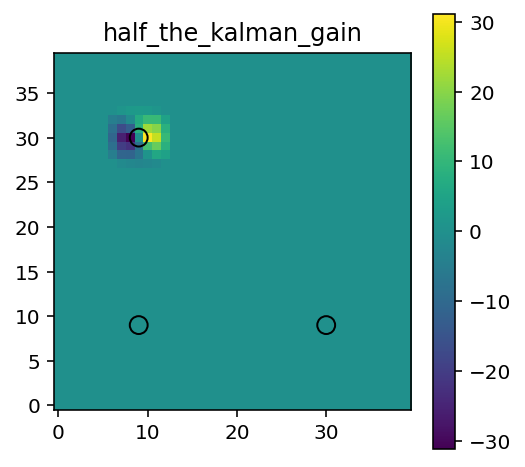

In [12]:
# Loop step 1: Pull particles towards observation by adding a Kalman gain term
#     Also, we find phi within this function
phi_array[0] = iewpfOcean.addKalmanGain(ensemble.particles[0], observed_drifter_positions, innovations[0])
print("phi: ", phi_array)

# Plot the resulting Kalman gain
K_eta, K_hu, K_hv = ensemble.particles[0].download(interior_domain_only=True)

half_the_kalman_gain = ensemble.particles[0].small_scale_model_error.getRandomNumbers()

for field, title in zip([K_eta, K_hu, K_hv, half_the_kalman_gain], 
                        ["K_eta", "K_hu", "K_hv", "half_the_kalman_gain"]):
    fig = plt.figure(figsize=(4,4))
    ax = plt.subplot(1, 1, 1)
    plt.imshow(field, interpolation='None', origin='lower')
    plt.title(title)
    if field.shape[0] < sim_args["ny"]:
        EnsemblePlot._markDriftersInImshow(ax, ensemble, observed_drifter_positions/sim_args["small_scale_perturbation_interpolation_factor"])
    else:
        EnsemblePlot._markDriftersInImshow(ax, ensemble, observed_drifter_positions)
    plt.colorbar()
    


Sample $\xi \sim N(0, P)$. With this function we only apply the SVD result to the standard normal distributed field.

gamma:  [43187.44592285     0.             0.             0.
     0.        ]
nu_norms:  [43260.37097168     0.             0.             0.
     0.        ]
std_norm_rand dot std_norm_pend =  1.9073486e-06
std_norm_pend dot std_norm_pend =  1602.2357
std_norm_rand dot std_norm_rand =  1599.535

svd_rand dot svd_pend =  1.9073486e-06
svd_pend dot svd_pend =  1602.2357
svd_rand dot svd_rand =  1599.535


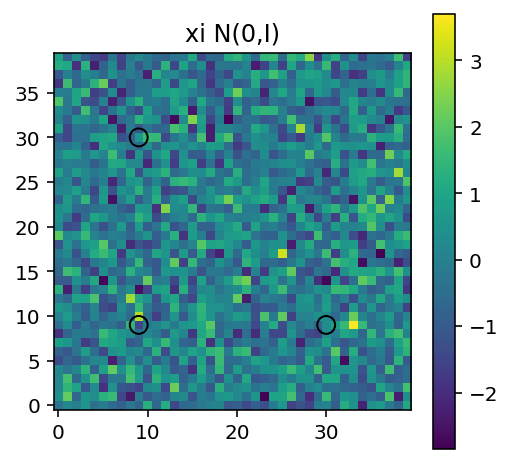

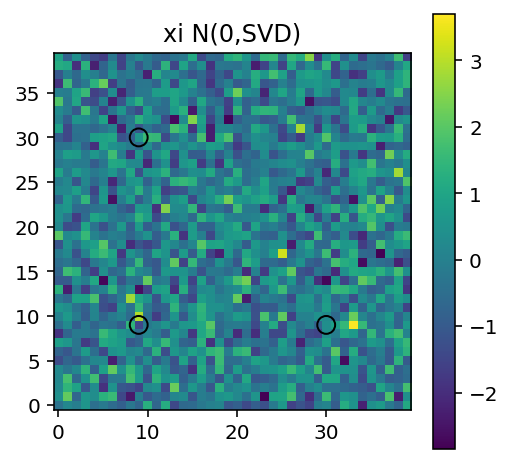

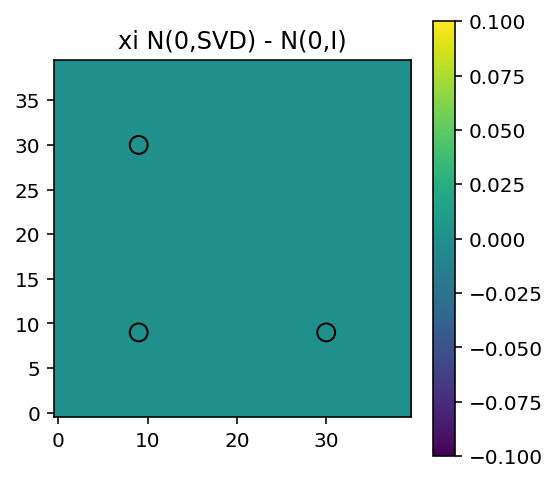

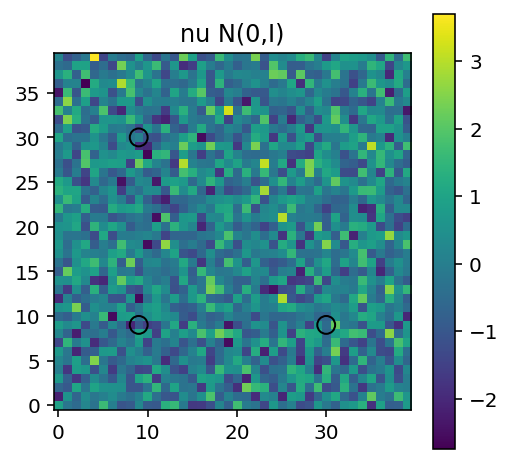

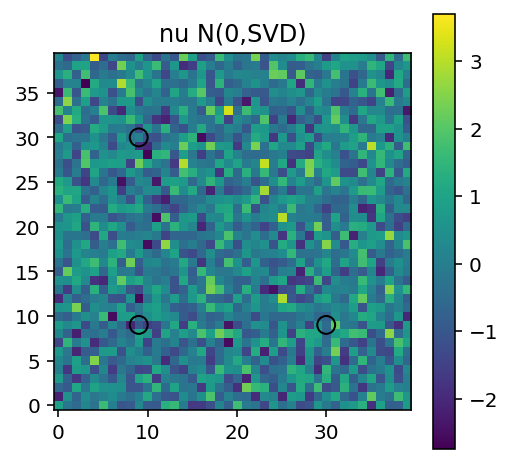

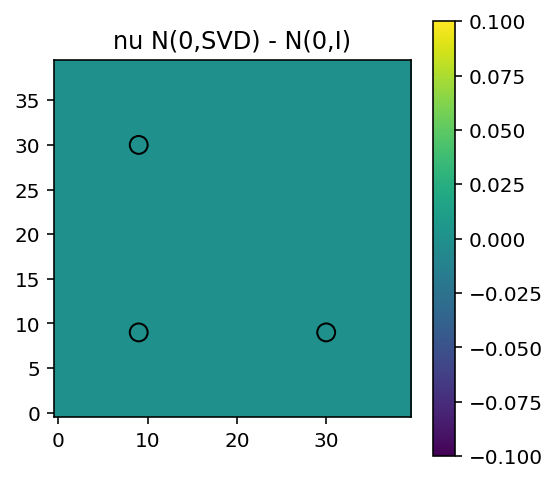

In [13]:
# Loop step 2: Sample xi \sim N(0, P), and get gamma in the process
gamma_array[0], nu_norm_array[0], std_norm_rand, std_norm_pend =\
    iewpfOcean.samplePerpendicular(ensemble.particles[0],
                                   return_original_random_numbers=True)
print("gamma: ", gamma_array)
print("nu_norms: ", nu_norm_array)

svd_rand = ensemble.particles[0].small_scale_model_error.getRandomNumbers()
svd_pend = ensemble.particles[0].small_scale_model_error.getPerpendicularRandomNumbers()

#imshow3(std_norm_rand, svd_rand, svd_rand-std_norm_rand,
#       title="xi N(0,I), xi N(0,SVD), xi N(0,SVD) - N(0,I)")
#imshow3(std_norm_pend, svd_pend, svd_pend-std_norm_pend,
#       title="nu N(0,I), nu N(0,SVD), nu N(0,SVD) - N(0,I)")

for field, title in zip([std_norm_rand, svd_rand, svd_rand-std_norm_rand], 
                        ["xi N(0,I)", "xi N(0,SVD)", "xi N(0,SVD) - N(0,I)"]):
    fig = plt.figure(figsize=(4,4))
    ax = plt.subplot(1, 1, 1)
    plt.imshow(field, interpolation='None', origin='lower')
    plt.title(title)
    EnsemblePlot._markDriftersInImshow(ax, ensemble, observed_drifter_positions/sim_args["small_scale_perturbation_interpolation_factor"])
    plt.colorbar()

for field, title in zip([std_norm_pend, svd_pend, svd_pend-std_norm_pend], 
                        ["nu N(0,I)", "nu N(0,SVD)", "nu N(0,SVD) - N(0,I)"]):
    fig = plt.figure(figsize=(4,4))
    ax = plt.subplot(1, 1, 1)
    plt.imshow(field, interpolation='None', origin='lower')
    plt.title(title)
    EnsemblePlot._markDriftersInImshow(ax, ensemble, observed_drifter_positions/sim_args["small_scale_perturbation_interpolation_factor"])
    plt.colorbar()

print("std_norm_rand dot std_norm_pend = ", np.sum(std_norm_rand*std_norm_pend))
print("std_norm_pend dot std_norm_pend = ", np.sum(std_norm_pend*std_norm_pend))
print("std_norm_rand dot std_norm_rand = ", np.sum(std_norm_rand*std_norm_rand))
print("")
print("svd_rand dot svd_pend = ", np.sum(svd_rand*svd_pend))
print("svd_pend dot svd_pend = ", np.sum(svd_pend*svd_pend))
print("svd_rand dot svd_rand = ", np.sum(svd_rand*svd_rand))


**Catch up** with the rest of the particles 

In [14]:
for p in range(1, ensemble.getNumParticles()):
    # Pull particles towards observation by adding a Kalman gain term
    #     Also, we find phi within this function
    phi_array[p] = iewpfOcean.addKalmanGain(ensemble.particles[p], observed_drifter_positions, innovations[p])

    # Sample perpendicular xi and nu, and apply the SVD to both fields
    # Obtain gamma = xi^T * xi and nu^T * nu at the same time
    gamma_array[p], nu_norm_array[p] = iewpfOcean.samplePerpendicular(ensemble.particles[p])
    
print("phi_array:     ", phi_array)  
print("gamma_array:   ", gamma_array)
print("nu_norm_array: ", nu_norm_array)

phi_array:      [59680.30826965  1805.16461135   513.44491662   517.69488738
   376.51133361]
gamma_array:    [43187.44592285 41837.38330078 42633.10876465 42392.14892578
 43660.19311523]
nu_norm_array:  [43260.37097168 41946.1842041  43292.62133789 43619.27453613
 41472.69543457]


Obtain **beta and target weight**
We don't use the information from the first artificial 

In [15]:
use_zero_particle = False
c_array = phi_array + w_rest
if use_zero_particle:
    target_weight, beta = iewpfOcean.obtainTargetWeightTwoStage(c_array, 
                                                                nu_norm_array)
else:
    target_weight, beta = iewpfOcean.obtainTargetWeightTwoStage(c_array[1:],
                                                                nu_norm_array[1:])
print("target_weight: ", target_weight)
print("beta: ", beta)

target_weight:  804.8133751550941
beta:  0.9761131866194711


**Solve implicit equation**

In [16]:
# Loop step 3: Solve implicit equation
c_star = target_weight - (c_array[0]) - (beta - 1)*nu_norm_array[0]
alpha = iewpfOcean.solveImplicitEquation(gamma_array[0], target_weight, 
                                         w_rest[0], c_star, 
                                         particle_id=0)
print("alpha: ", alpha)
if alpha < 0:
    alpha = -alpha

# Since the ocean field is sat to zero, we accept alpha=nan

alpha:  0.079954423225673


In [17]:
## Apply SCV to perpendicular
iewpfOcean.applySVDtoPerpendicular(ensemble.particles[0], observed_drifter_positions,
                                 alpha, beta)


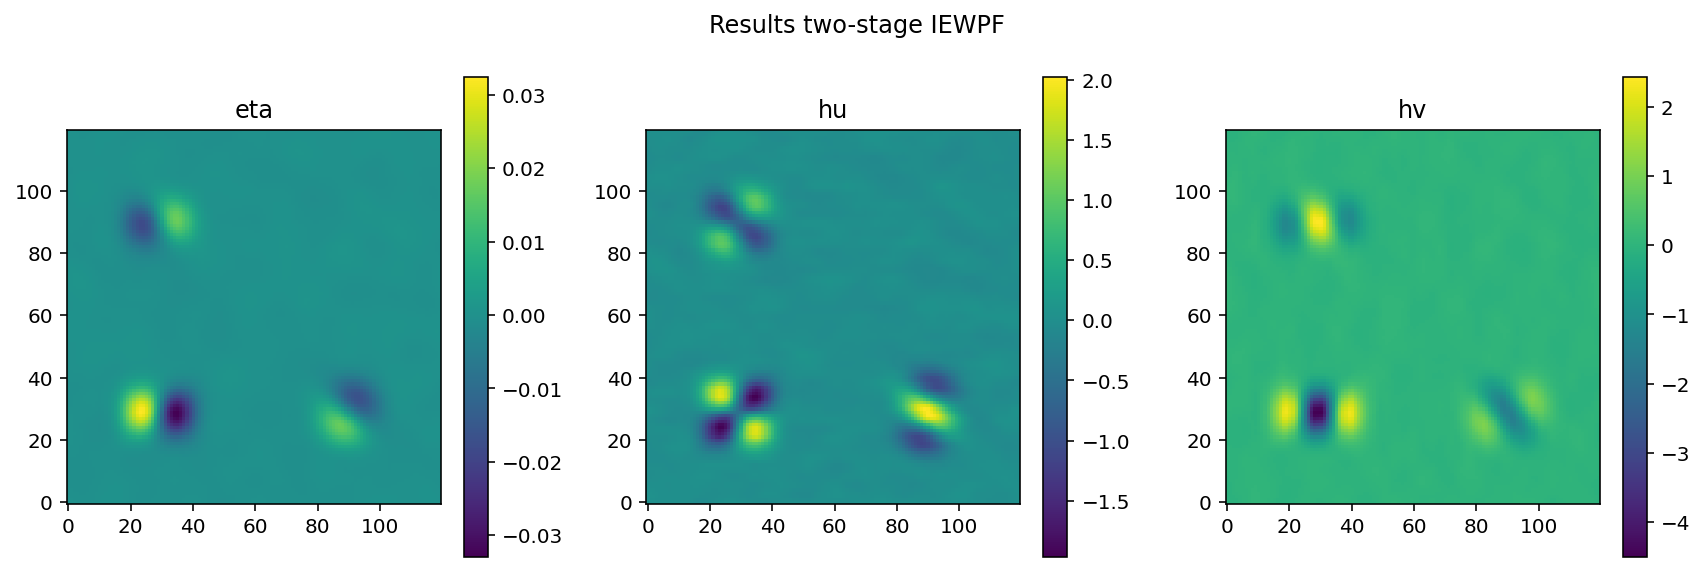

In [18]:
# Add scaled sample from P to the state vector
ensemble.particles[0].small_scale_model_error.perturbSim(ensemble.particles[0],\
                                                         update_random_field=False, \
                                                         perturbation_scale=alpha,
                                                         perpendicular_scale=beta)  
# Plot the resulting Kalman gain
res_eta, res_hu, res_hv = ensemble.particles[0].download(interior_domain_only=True)
imshow3(res_eta, res_hu, res_hv, title="Results two-stage IEWPF")

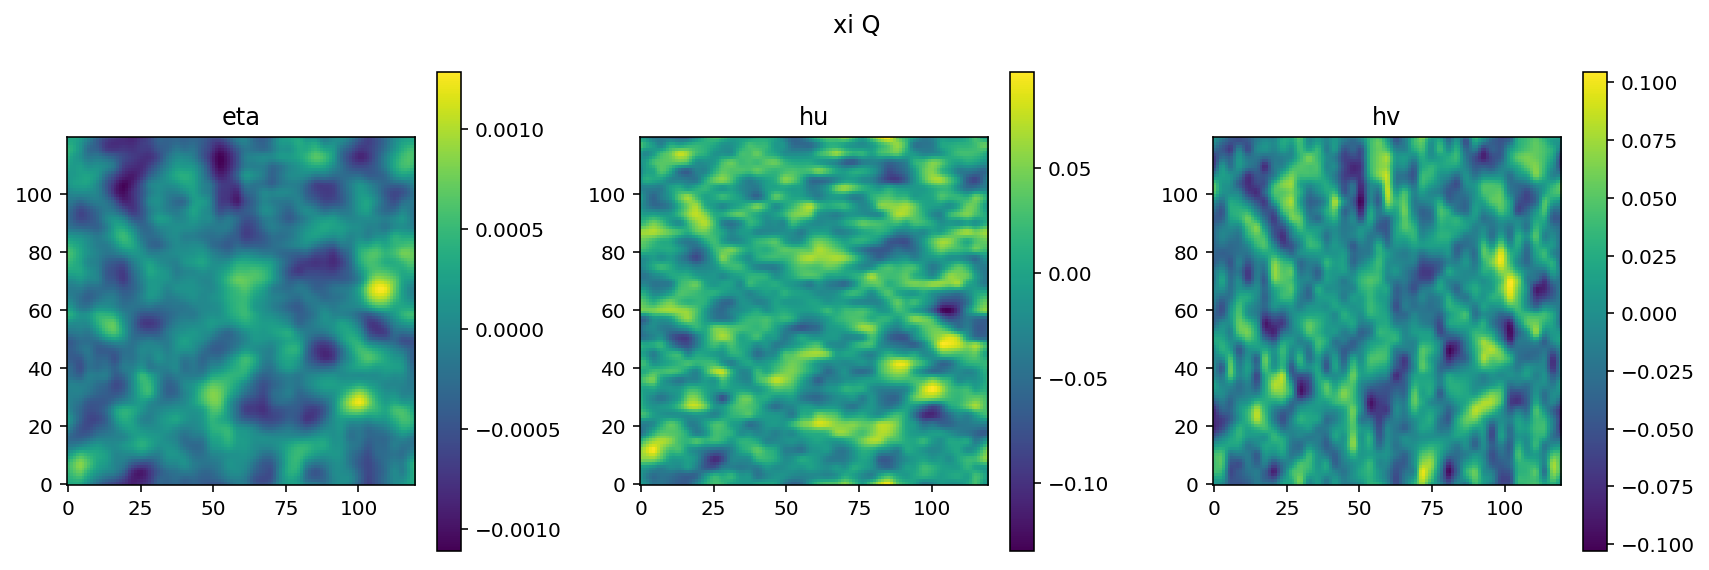

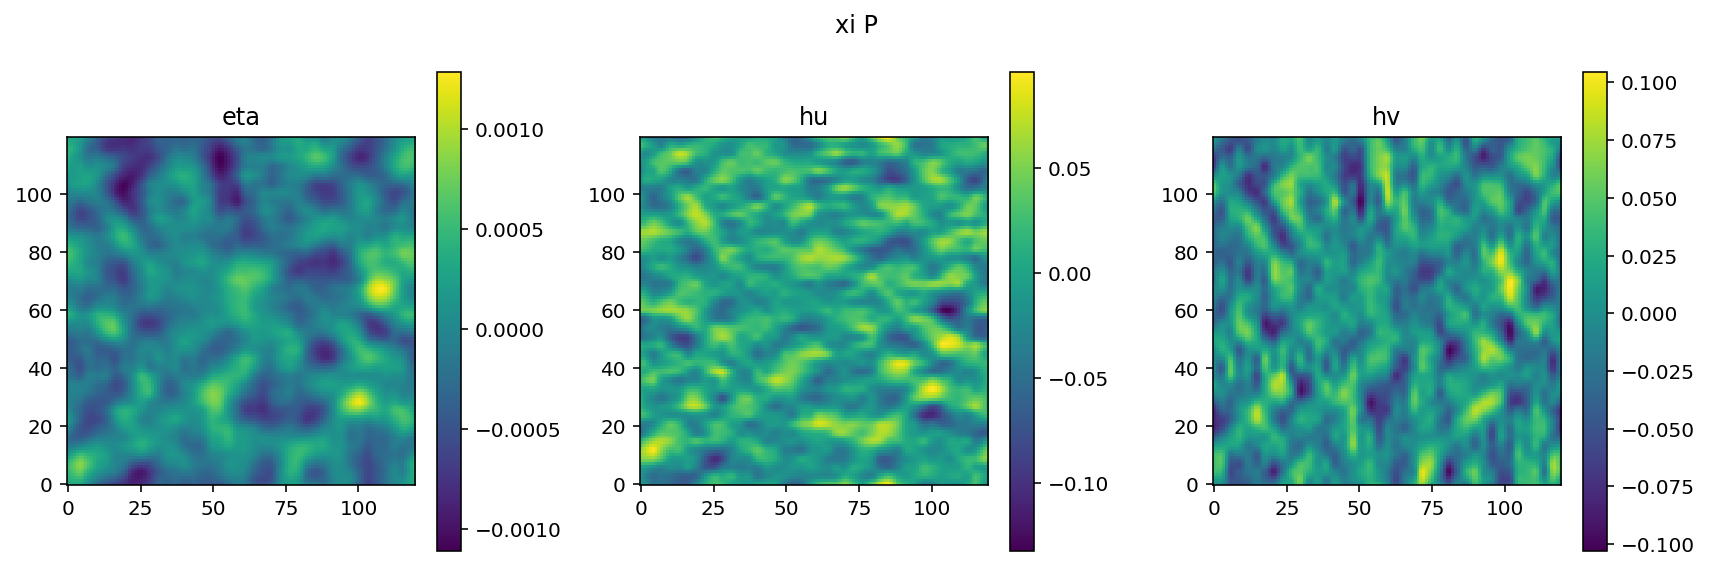

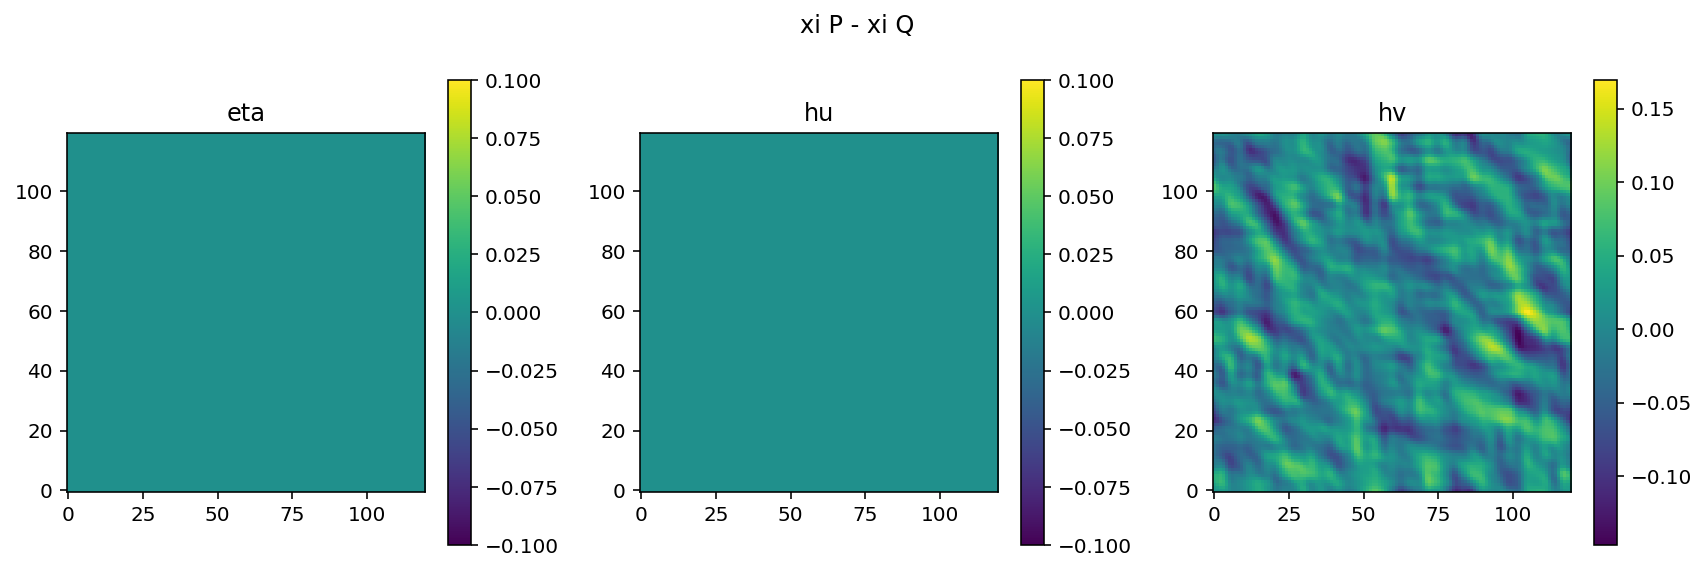

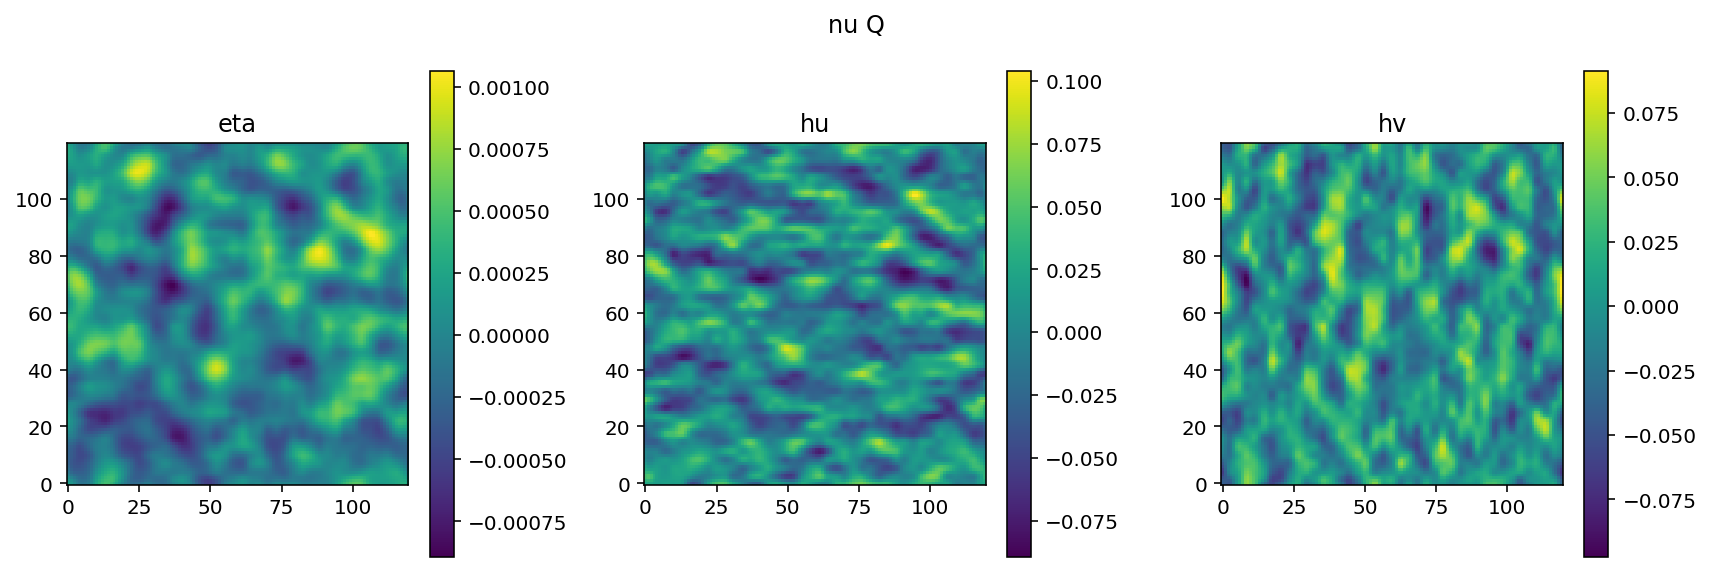

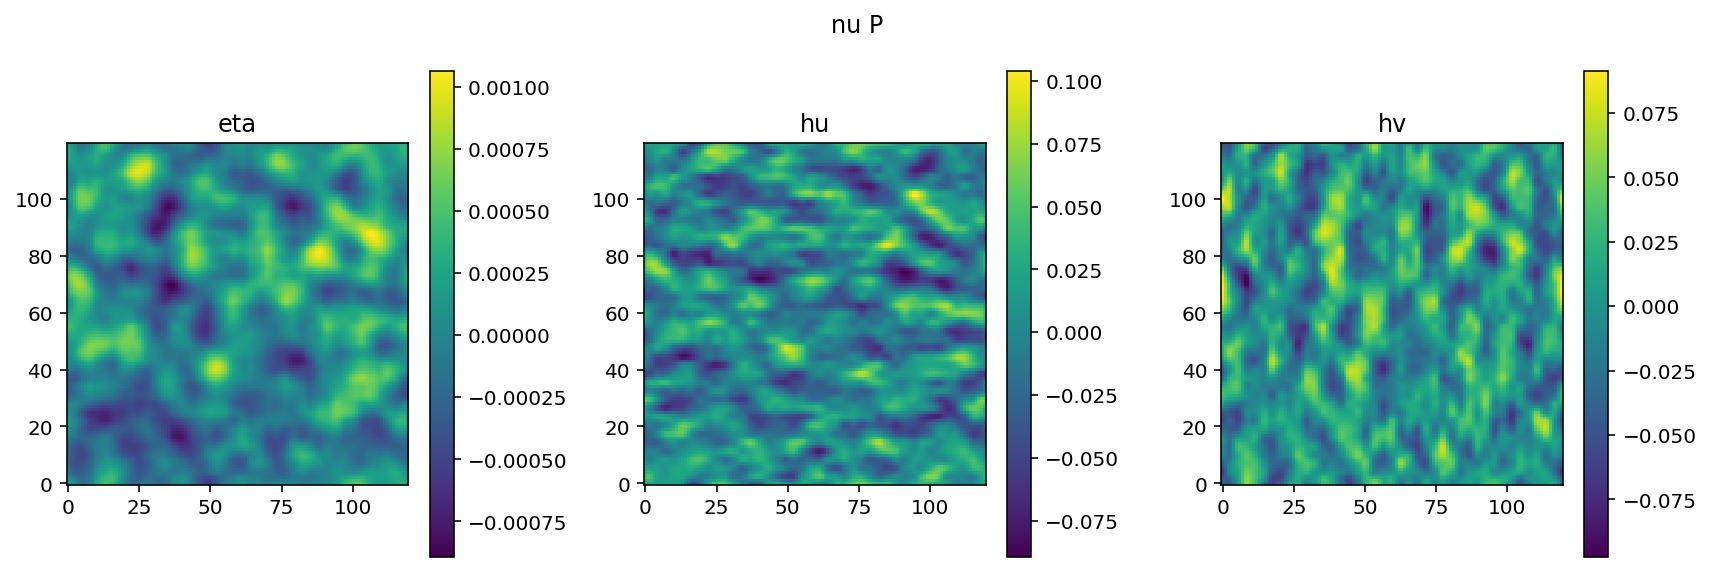

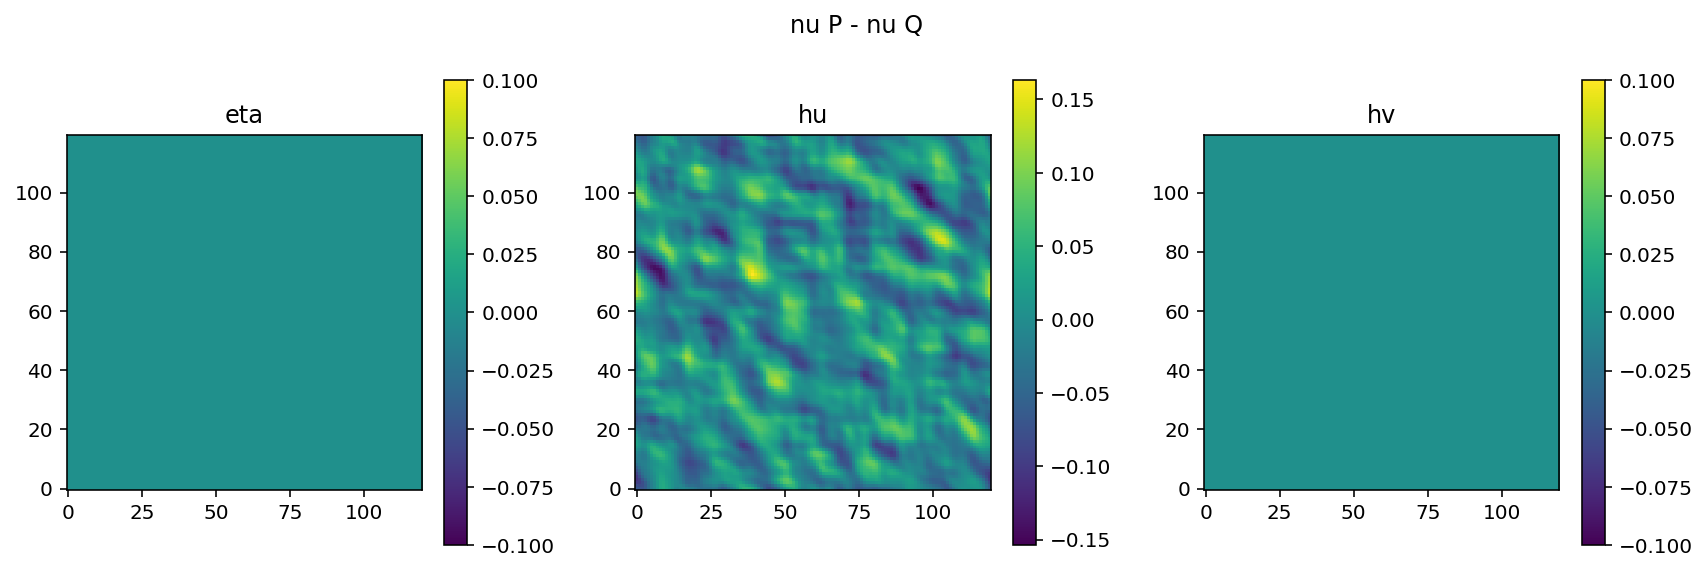

In [19]:
# Investigate how the xi sim N(0, P) was added to the solution

# From xi N(0, P):
eta_xi_P, hu_xi_P, hv_xi_P = np.zeros(dataShape), np.zeros(dataShape), np.zeros(dataShape)
ensemble.particles[0].small_scale_model_error.random_numbers_host = svd_rand
ensemble.particles[0].small_scale_model_error.perturbOceanStateCPU(eta_xi_P, hu_xi_P, hv_xi_P,
                                                                   sim_args["H"], sim_args["f"], 
                                                                   ghost_cells_x=2, ghost_cells_y=2,
                                                                   use_existing_CPU_random_numbers=True)
# From xi N(0, Q):
eta_xi_Q, hu_xi_Q, hv_xi_Q = np.zeros(dataShape), np.zeros(dataShape), np.zeros(dataShape)
ensemble.particles[0].small_scale_model_error.random_numbers_host = std_norm_rand
ensemble.particles[0].small_scale_model_error.perturbOceanStateCPU(eta_xi_Q, hu_xi_Q, hv_xi_Q,
                                                                   sim_args["H"], sim_args["f"], 
                                                                   ghost_cells_x=2, ghost_cells_y=2,
                                                                   use_existing_CPU_random_numbers=True)

# From nu N(0, P):
eta_nu_P, hu_nu_P, hv_nu_P = np.zeros(dataShape), np.zeros(dataShape), np.zeros(dataShape)
ensemble.particles[0].small_scale_model_error.random_numbers_host = svd_pend
ensemble.particles[0].small_scale_model_error.perturbOceanStateCPU(eta_nu_P, hu_nu_P, hv_nu_P,                                                                   sim_args["H"], sim_args["f"], 
                                                                   ghost_cells_x=2, ghost_cells_y=2,
                                                                   use_existing_CPU_random_numbers=True)
# From nu N(0, Q):
eta_nu_Q, hu_nu_Q, hv_nu_Q = np.zeros(dataShape), np.zeros(dataShape), np.zeros(dataShape)
ensemble.particles[0].small_scale_model_error.random_numbers_host = std_norm_pend
ensemble.particles[0].small_scale_model_error.perturbOceanStateCPU(eta_nu_Q, hu_nu_Q, hv_nu_Q,                                                                   sim_args["H"], sim_args["f"], 
                                                                   ghost_cells_x=2, ghost_cells_y=2,
                                                                   use_existing_CPU_random_numbers=True)

imshow3(eta_xi_Q, hu_xi_Q, hv_xi_Q, title="xi Q", interior=True)
imshow3(eta_xi_P, hu_xi_P, hv_xi_P, title="xi P", interior=True)
imshow3(eta_xi_P-eta_xi_Q, hu_xi_P-hu_xi_Q, hv_xi_P-hu_xi_Q, title="xi P - xi Q", interior=True)

imshow3(eta_nu_Q, hu_nu_Q, hv_nu_Q, title="nu Q", interior=True)
imshow3(eta_nu_P, hu_nu_P, hv_nu_P, title="nu P", interior=True)
imshow3(eta_nu_P-eta_nu_Q, hv_nu_P-hu_nu_Q, hv_nu_P-hv_nu_Q, title="nu P - nu Q", interior=True)



**Build the result from the CPU array**

(120, 120)
(124, 124)
(124, 124)
(120, 120)


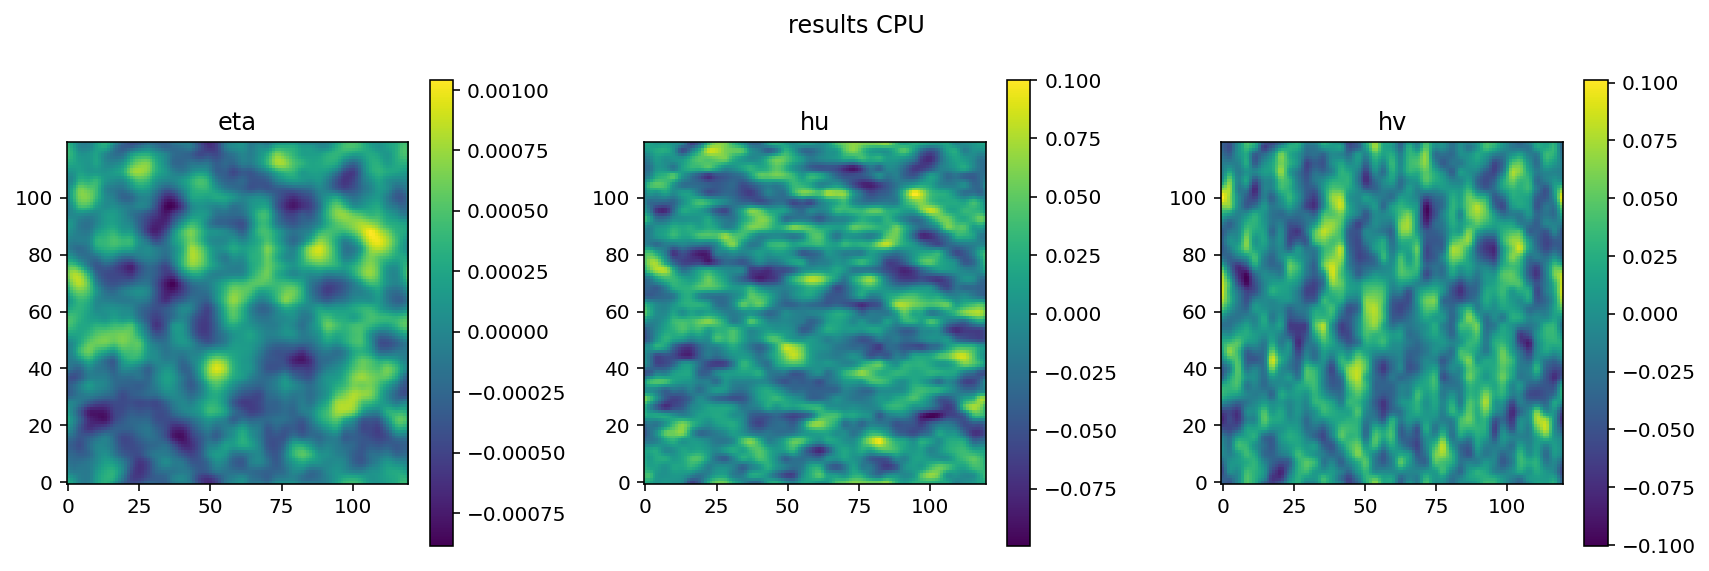

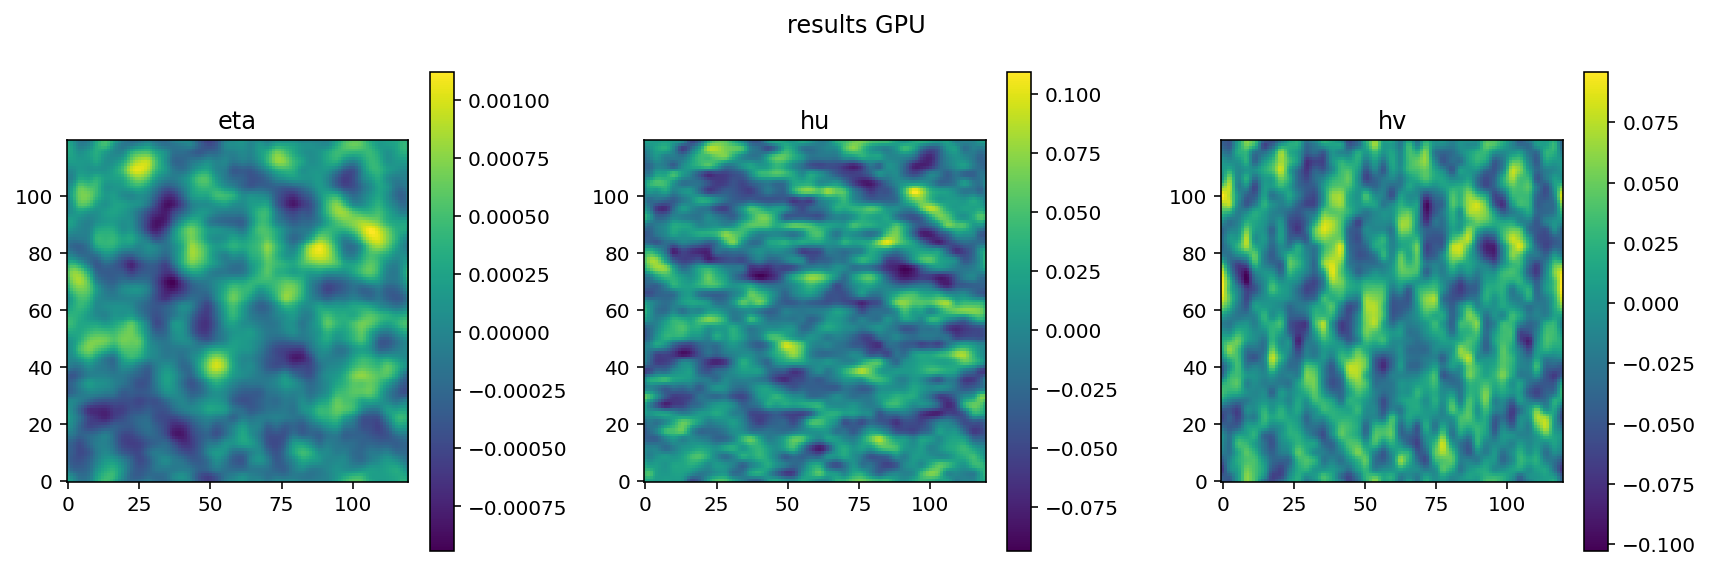

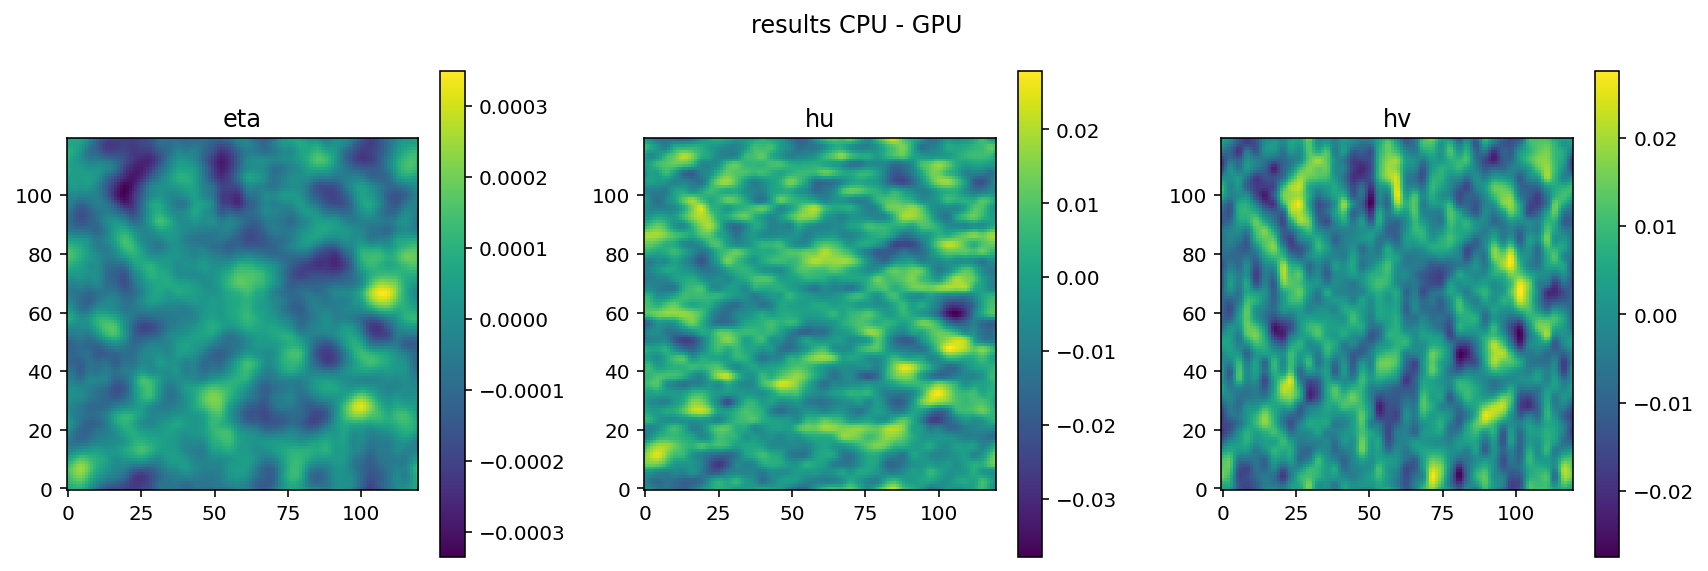

In [20]:
print(K_eta.shape)
print(eta_xi_P.shape)
print(eta_nu_P.shape)
print(res_eta.shape)

use_beta = np.sqrt(beta) #np.sqrt(beta)
use_alpha = np.sqrt(alpha) #alpha

#eta_res_CPU = K_eta + use_beta*eta_nu_P[2:-2,2:-2] + use_alpha*eta_xi_P[2:-2,2:-2]
#hu_res_CPU  = K_hu  + use_beta* hu_nu_P[2:-2,2:-2] + use_alpha* hu_xi_P[2:-2,2:-2]
#hv_res_CPU  = K_hv  + use_beta* hv_nu_P[2:-2,2:-2] + use_alpha* hv_xi_P[2:-2,2:-2]
eta_res_CPU = use_beta*eta_nu_P[2:-2,2:-2] + use_alpha*eta_xi_P[2:-2,2:-2]
hu_res_CPU  = use_beta* hu_nu_P[2:-2,2:-2] + use_alpha* hu_xi_P[2:-2,2:-2]
hv_res_CPU  = use_beta* hv_nu_P[2:-2,2:-2] + use_alpha* hv_xi_P[2:-2,2:-2]

res_eta_sub_K = res_eta - K_eta
res_hu_sub_K  = res_hu  - K_hu
res_hv_sub_K  = res_hv  - K_hv

imshow3(eta_res_CPU, hu_res_CPU, hv_res_CPU, title="results CPU")
#imshow3(res_eta, res_hu, res_hv, title="results GPU")
imshow3(res_eta_sub_K, res_hu_sub_K, res_hv_sub_K, title="results GPU")
imshow3(eta_res_CPU-res_eta_sub_K, hu_res_CPU-res_hu_sub_K, hv_res_CPU-res_hv_sub_K, title="results CPU - GPU")


In [21]:
sim.logger.getEffectiveLevel()


15